# <font color='darkblue'>**Speaker Recognition Using Siamese Neural Network**</font>

## IMPORTING LIBRARIES

In [ ]:
!pip install pydub

In [ ]:
import numpy as np
import pandas as pd
import random
import os
import seaborn as sns
from wordcloud import WordCloud
import shutil
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy import signal, fftpack
from scipy.io import wavfile
import soundfile as sf
from pathlib import Path
from IPython.display import display, Audio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import itertools

from pathlib import PurePath
from pydub import AudioSegment
from pathlib import Path
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torch.nn.functional import pairwise_distance
import torch.nn.functional as F
from torchsummary import summary
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## EDA

**SETUP**

In [ ]:
!wget https://www.openslr.org/resources/12/dev-clean.tar.gz -P ./dataset-speaker-recognition-librispeech/
!tar -xf ./dataset-speaker-recognition-librispeech/dev-clean.tar.gz -C ./dataset-speaker-recognition-librispeech/

--2024-05-22 11:08:46--  https://www.openslr.org/resources/12/dev-clean.tar.gz
Resolving www.openslr.org (www.openslr.org)... 46.101.158.64
Connecting to www.openslr.org (www.openslr.org)|46.101.158.64|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://openslr.trmal.net/resources/12/dev-clean.tar.gz [following]
--2024-05-22 11:08:47--  https://openslr.trmal.net/resources/12/dev-clean.tar.gz
Resolving openslr.trmal.net (openslr.trmal.net)... 136.243.171.4, 2a01:4f8:171:2012::2
Connecting to openslr.trmal.net (openslr.trmal.net)|136.243.171.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 337926286 (322M) [application/x-gzip]
Saving to: ‘./dataset-speaker-recognition-librispeech/dev-clean.tar.gz’

dev-clean.tar.gz    100%[===================>] 322.27M  13.1MB/s    in 27s     

2024-05-22 11:09:15 (12.0 MB/s) - ‘./dataset-speaker-recognition-librispeech/dev-clean.tar.gz’ saved [337926286/337926286]



In [ ]:
!wget https://www.openslr.org/resources/12/train-clean-100.tar.gz -P ./dataset-speaker-recognition-librispeech/
!tar -xf ./dataset-speaker-recognition-librispeech/train-clean-100.tar.gz -C ./dataset-speaker-recognition-librispeech/

--2024-06-04 19:17:22--  https://www.openslr.org/resources/12/train-clean-100.tar.gz
Resolving www.openslr.org (www.openslr.org)... 46.101.158.64
Connecting to www.openslr.org (www.openslr.org)|46.101.158.64|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://openslr.elda.org/resources/12/train-clean-100.tar.gz [following]
--2024-06-04 19:17:23--  https://openslr.elda.org/resources/12/train-clean-100.tar.gz
Resolving openslr.elda.org (openslr.elda.org)... 141.94.109.138, 2001:41d0:203:ad8a::
Connecting to openslr.elda.org (openslr.elda.org)|141.94.109.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6387309499 (5.9G) [application/x-gzip]
Saving to: ‘./dataset-speaker-recognition-librispeech/train-clean-100.tar.gz’

train-clean-100.tar 100%[===================>]   5.95G  42.7MB/s    in 2m 54s  

2024-06-04 19:20:18 (34.9 MB/s) - ‘./dataset-speaker-recognition-librispeech/train-clean-100.tar.gz’ saved [6387309499/6387309499]

In [ ]:
import os

# Path to the extracted train-clean-100 directory
libri_dir = "dataset-speaker-recognition-librispeech/LibriSpeech"
speakers_file = os.path.join(libri_dir, "SPEAKERS.TXT")

# Parse the SPEAKERS.TXT file
speaker_info = {}
with open(speakers_file, 'r') as f:
    for line in f:
        if line.startswith(';'):
            continue
        parts = line.strip().split()
        speaker_id = parts[0]
        speaker_name = parts[-1]
        speaker_info[speaker_id] = speaker_name

# Example: Retrieve speaker name for a given file
example_file = "84/121123/84-121123-0001.flac"
speaker_id = example_file.split('/')[0]
print(f"Speaker ID: {speaker_id}, Speaker Name: {speaker_info.get(speaker_id, 'Unknown')}")

Speaker ID: 84, Speaker Name: Nowak


In [ ]:
def create_librispeech_dataframe(libri_dir):
    # Path to the SPEAKERS.TXT file
    speakers_file = os.path.join(libri_dir, "..", "SPEAKERS.TXT")

    # Parse the SPEAKERS.TXT file to create a mapping of speaker IDs to names and genders
    speaker_info = {}
    with open(speakers_file, 'r') as f:
        for line in f:
            if line.startswith(';'):
                continue
            parts = line.strip().split()
            speaker_id = parts[0]
            gender = parts[2]
            duration = parts[6]
            speaker_name = parts[8]+ ' '+ parts[-1]
            speaker_info[speaker_id] = (speaker_name, gender,duration)

    # Initialize lists to store data for the DataFrame
    audio_paths = []
    speaker_names = []
    genders = []
    durations = []

    # Walk through the directory structure and collect audio file paths, speaker names, and genders
    for root, _, files in os.walk(libri_dir):
        for file in files:
            if file.endswith(".flac"):
                file_path = os.path.join(root, file)
                speaker_id = file_path.split(os.sep)[-3]
                speaker_name, gender,duration = speaker_info.get(speaker_id, ('Unknown', 'Unknown','Unknown'))
                audio_paths.append(file_path)
                speaker_names.append(speaker_name)
                genders.append(gender)
                durations.append(duration)

    # Create a DataFrame
    df = pd.DataFrame({
        'audio_path': audio_paths,
        'speaker_name': speaker_names,
        'gender': genders,
        'duration': durations
    })

    return df

# Usage example
libri_dir = "dataset-speaker-recognition-librispeech/LibriSpeech/train-clean-100"
df = create_librispeech_dataframe(libri_dir)
print(df.head())

                                          audio_path  speaker_name gender  \
0  dataset-speaker-recognition-librispeech/LibriS...  Aaron Teiser      M   
1  dataset-speaker-recognition-librispeech/LibriS...  Aaron Teiser      M   
2  dataset-speaker-recognition-librispeech/LibriS...  Aaron Teiser      M   
3  dataset-speaker-recognition-librispeech/LibriS...  Aaron Teiser      M   
4  dataset-speaker-recognition-librispeech/LibriS...  Aaron Teiser      M   

  duration  
0    19.00  
1    19.00  
2    19.00  
3    19.00  
4    19.00  


In [ ]:
df.isnull().sum()

audio_path      0
speaker_name    0
gender          0
duration        0
dtype: int64

In [ ]:
# Identifier les doublons
duplicates = df.duplicated()

# Afficher les lignes en double (index)
print(df[duplicates])

Empty DataFrame
Columns: [audio_path, speaker_name, gender, duration]
Index: []


In [ ]:
speaker_groups = df.groupby('speaker_name')
speaker_counts = speaker_groups.size()
print(speaker_counts)

speaker_name
A. Risa                       81
Aaron Teiser                  89
Adam Picot                   118
Alan (1945-2010)             122
Alex Buie                    137
                            ... 
toriasuncle toriasuncle      110
treefingers treefingers      123
webslog webslog              131
xinamarieuhl xinamarieuhl    110
|CBW|Simon |CBW|Simon         97
Length: 251, dtype: int64


In [ ]:
# First quartile
q1 = speaker_counts.quantile(0.25)
q3 = speaker_counts.quantile(0.75)  # Third quartile
iqr = q3 - q1  # Interquartile range

lower_bound = q1 - 1.5 * iqr # Lower bound for outliers

upper_bound = q3 + 1.5 * iqr # Upper bound for outliers

outliers = speaker_counts[(speaker_counts < lower_bound) | (speaker_counts > upper_bound)]

mean_count = speaker_counts.mean()

std_dev = speaker_counts.std()

threshold = 3

z_scores = np.abs(speaker_counts - mean_count) / std_dev

outliers = speaker_counts[z_scores > threshold]

print("Outliers:", outliers)

Outliers: speaker_name
Dave Foss                   60
Karen Labenz               161
Michelle White              56
Tom Clifton                165
nkneer nkneer               26
roolynninms roolynninms     66
shanda_w shanda_w          166
dtype: int64


Value counts before balancing:
count    251.000000
mean     113.701195
std       15.211652
min       26.000000
25%      108.000000
50%      114.000000
75%      121.500000
max      166.000000
Name: count, dtype: float64
Value counts after balancing:
count    251.000000
mean     113.629482
std       10.605384
min       90.000000
25%      108.000000
50%      114.000000
75%      121.500000
max      130.000000
Name: count, dtype: float64


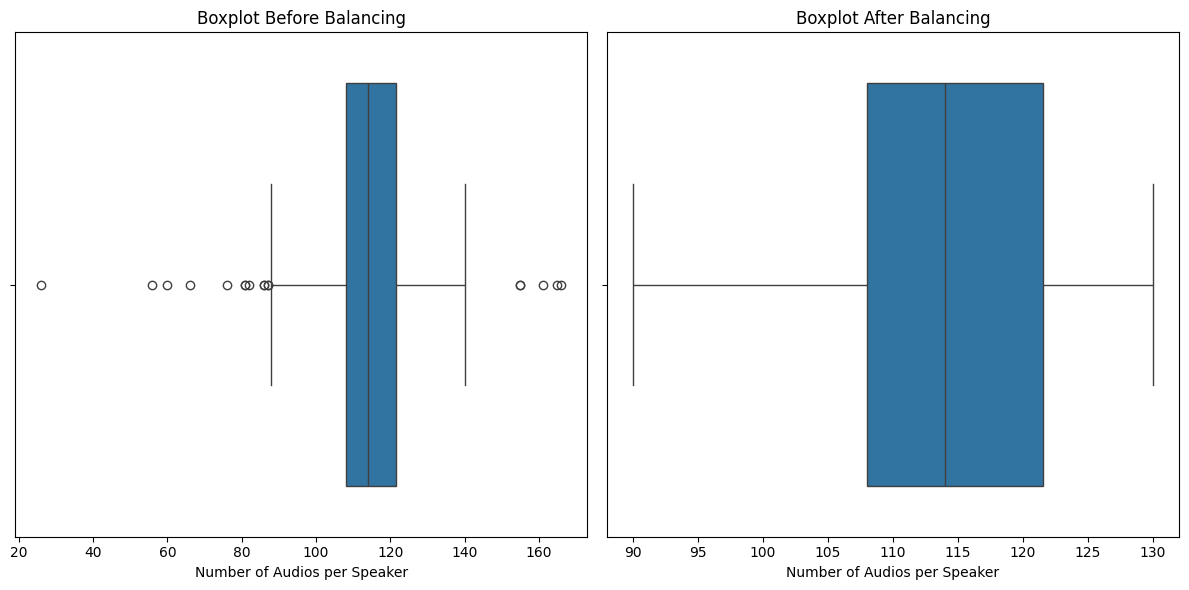

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample

def balance_dataset(df, min_audios=90, max_audios=130):
    # Find the counts of each speaker
    speaker_counts = df['speaker_name'].value_counts()

    # Create a balanced dataframe
    balanced_df = pd.DataFrame()

    for speaker, count in speaker_counts.items():
        speaker_df = df[df['speaker_name'] == speaker]

        if count > max_audios:
            # Sub-sample to the max_audios count
            speaker_df = resample(speaker_df, replace=False, n_samples=max_audios, random_state=42)
        elif count < min_audios:
            # Over-sample to the min_audios count
            speaker_df = resample(speaker_df, replace=True, n_samples=min_audios, random_state=42)

        balanced_df = pd.concat([balanced_df, speaker_df])

    return balanced_df

# Usage example
libri_dir = "dataset-speaker-recognition-librispeech/LibriSpeech/train-clean-100"
df = create_librispeech_dataframe(libri_dir)

# Balance the dataset
balanced_df = balance_dataset(df)

# Check the value counts before and after balancing
print("Value counts before balancing:")
print(df['speaker_name'].value_counts().describe())

print("Value counts after balancing:")
print(balanced_df['speaker_name'].value_counts().describe())

# Plot the boxplot before balancing
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x=df['speaker_name'].value_counts())
plt.title('Boxplot Before Balancing')
plt.xlabel('Number of Audios per Speaker')

# Plot the boxplot after balancing
plt.subplot(1, 2, 2)
# To ensure better visualization, add jitter to the value counts
sns.boxplot(x=balanced_df['speaker_name'].value_counts())
plt.title('Boxplot After Balancing')
plt.xlabel('Number of Audios per Speaker')

plt.tight_layout()
plt.show()

In [ ]:
len(df['speaker_name'].unique())

251

**Distribution of audio lengths in the dataset**

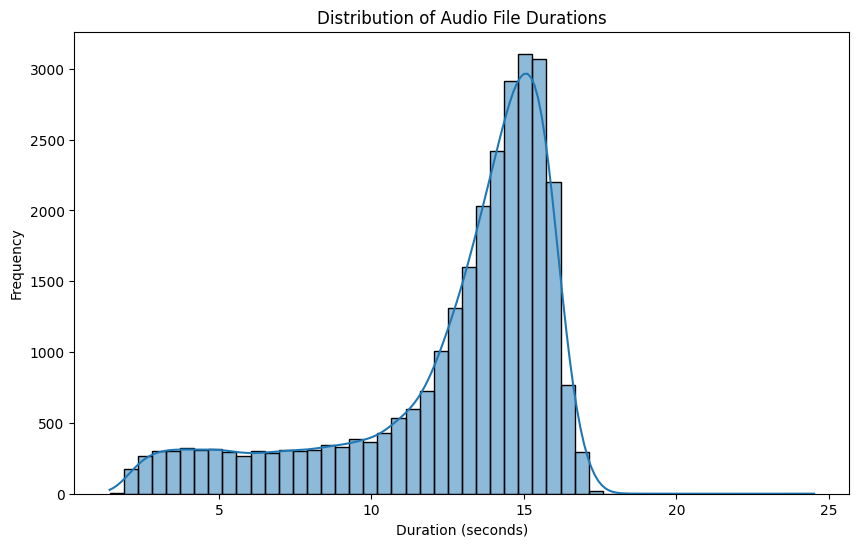

In [ ]:
import soundfile as sf

def get_audio_duration(file_path):
    f = sf.SoundFile(file_path)
    return len(f) / f.samplerate

df['duration'] = df['audio_path'].apply(get_audio_duration)

plt.figure(figsize=(10, 6))
sns.histplot(df['duration'], bins=50, kde=True)
plt.title('Distribution of Audio File Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.show()


**Speaker Distribution**

In [ ]:
speaker_counts = df['speaker_name'].value_counts()
mean_audio_files = speaker_counts.mean()
std_dev_audio_files = speaker_counts.std()
coeff_variation = std_dev_audio_files / mean_audio_files

print(f'Mean number of audio files: {mean_audio_files}')
print(f'Standard deviation of audio files: {std_dev_audio_files}')
print(f'Coefficient of variation: {coeff_variation}')

Mean number of audio files: 113.7011952191235
Standard deviation of audio files: 15.21165206562841
Coefficient of variation: 0.133786210745742


In [ ]:
import numpy as np

def gini_coefficient(x):
    # The array must be sorted
    x_sorted = np.sort(x)
    n = x_sorted.size
    cumulative_sum = np.cumsum(x_sorted)
    relative_mean_difference = (n + 1 - 2 * np.cumsum(cumulative_sum / cumulative_sum[-1])) / n
    return np.mean(relative_mean_difference)

gini = gini_coefficient(speaker_counts.values)
print(f'Gini Coefficient: {gini}')

Gini Coefficient: 0.7008969152782489


Moyenne (Mean)
La moyenne indique le nombre moyen de fichiers audio par locuteur.

Valeur : 116.49 (environ)
Interprétation : En moyenne, chaque locuteur a environ 116 fichiers audio.
2. Écart-Type (Standard Deviation)
L'écart-type mesure la dispersion des données par rapport à la moyenne.

Valeur : 24.37 (environ)
Interprétation : Les nombres de fichiers audio par locuteur varient en moyenne de 24.37 fichiers autour de la moyenne de 116.49. Un écart-type plus élevé indiquerait une plus grande variation dans les données.
3. Coefficient de Variation (Coefficient of Variation)
Le coefficient de variation est une mesure standardisée de la dispersion. Il est calculé comme l'écart-type divisé par la moyenne.

Valeur : 0.209 (environ)
Interprétation : Un coefficient de variation de 0.209 indique que l'écart-type est environ 20.9% de la moyenne. Cela signifie qu'il y a une certaine variation dans le nombre de fichiers audio par locuteur, mais cette variation est relativement modérée par rapport à la moyenne.
Interprétation Globale
Distribution Relativement Homogène : Un coefficient de variation de 0.209 signifie que la distribution est relativement homogène. Une valeur inférieure à 0.5 est généralement considérée comme une indication que la dispersion est faible par rapport à la moyenne.

Pas de Variation Extrême : Avec une moyenne de 116.49 fichiers audio et un écart-type de 24.37, la majorité des locuteurs ont un nombre de fichiers audio qui se situe entre 92 (116.49 - 24.37) et 140 (116.49 + 24.37). Il n'y a donc pas de variation extrême.

Équité Relative : La distribution des fichiers audio par locuteur semble assez équitable. Il n'y a pas de locuteurs avec des quantités de fichiers audio extrêmement différentes de la moyenne.

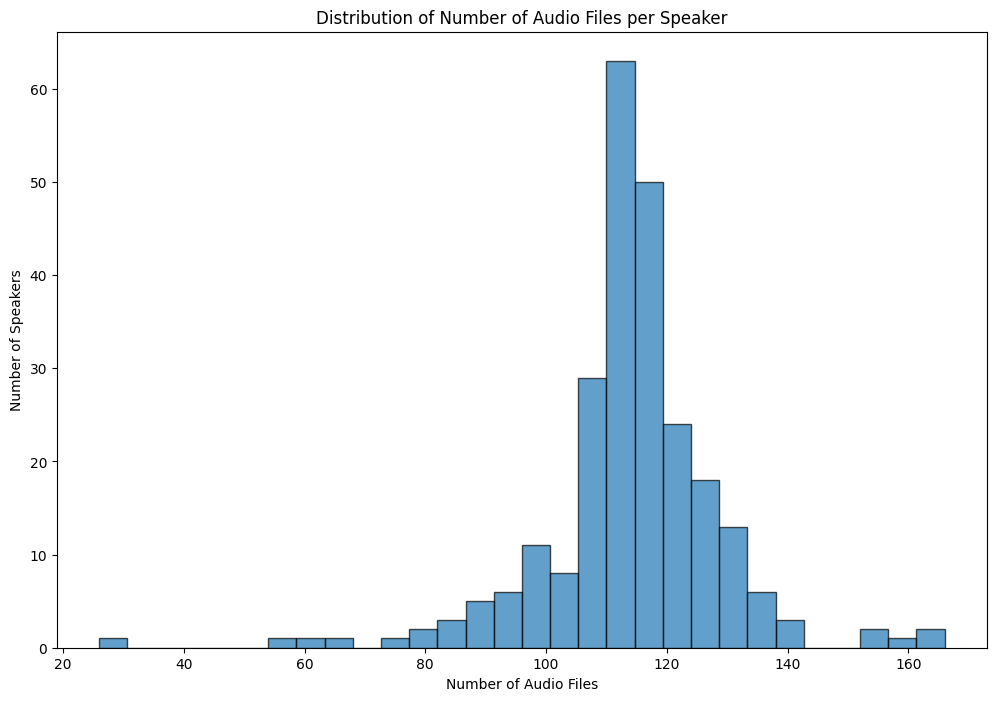

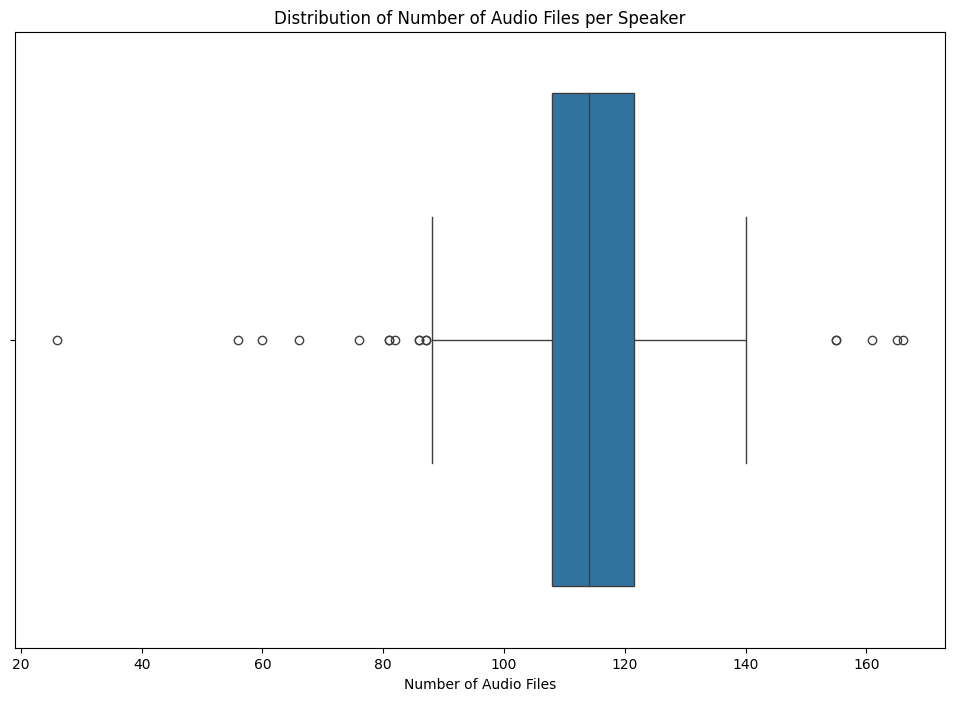

In [ ]:
# Histogramme
plt.figure(figsize=(12, 8))
plt.hist(speaker_counts.values, bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Number of Audio Files per Speaker')
plt.xlabel('Number of Audio Files')
plt.ylabel('Number of Speakers')
plt.show()

# Box Plot
plt.figure(figsize=(12, 8))
sns.boxplot(x=speaker_counts.values)
plt.title('Distribution of Number of Audio Files per Speaker')
plt.xlabel('Number of Audio Files')
plt.show()

**Gender Distribution**

<ipython-input-11-a95cdd20bdfa>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gender_counts.index, y=gender_counts.values, palette=palette)


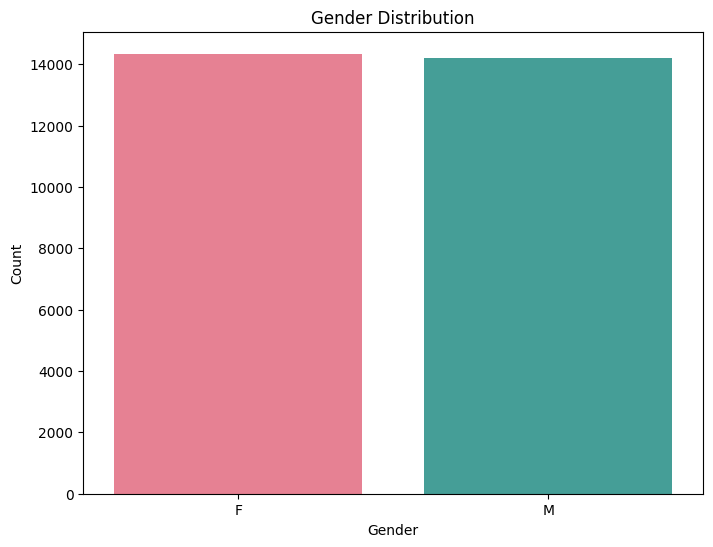

In [ ]:
# Count the occurrences of each gender
gender_counts = df['gender'].value_counts()

# Create a color palette
palette = sns.color_palette("husl", len(gender_counts))

# Plot the barplot with specified colors
plt.figure(figsize=(8, 6))
sns.barplot(x=gender_counts.index, y=gender_counts.values, palette=palette)
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

**Word Cloud of Transcripts**

In [ ]:
# Assuming you have a column `transcript` in your dataframe
text = " ".join(df['transcript'].dropna().values)
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(text)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Transcripts')
plt.show()

**Distribution of Speaker By Duration**

<ipython-input-15-8ba10bf0cd8f>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=speaker_duration_hours.index, y=speaker_duration_hours.values, palette="viridis")


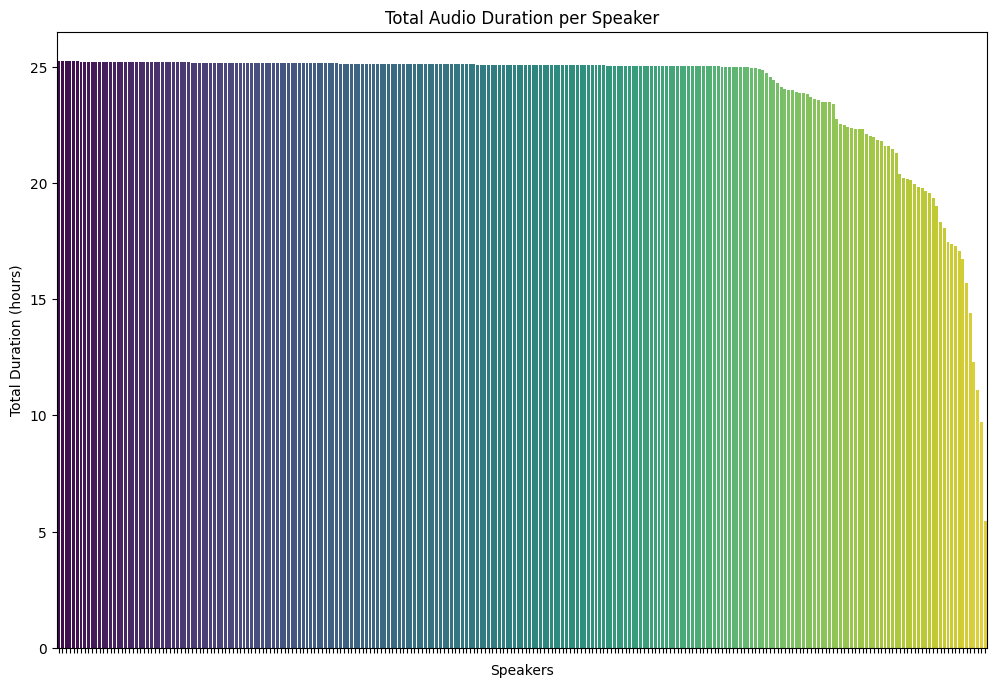

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert duration to numeric values
df['duration'] = pd.to_numeric(df['duration'], errors='coerce')

# Group by speaker and sum the durations, then sort
speaker_duration = df.groupby('speaker_name')['duration'].sum().sort_values(ascending=False)

# Convert duration from minutes to hours
speaker_duration_hours = speaker_duration / 60  # dividing by 60 to convert from minutes to hours

# Create the bar plot
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=speaker_duration_hours.index, y=speaker_duration_hours.values, palette="viridis")
plt.title('Total Audio Duration per Speaker')
plt.xlabel('Speakers')
plt.ylabel('Total Duration (hours)')

# Remove y-axis labels
ax.set_xticklabels([])

plt.show()

In [ ]:
def create_pairs(df):
    pairs = []
    labels = []

    # Group DataFrame by speaker_name
    grouped = df.groupby('speaker_name')

    # List to store positive pairs
    positive_pairs = []
    created_pairs = set()  # Set to track unique pairs

    # Create positive pairs (same speaker)
    for speaker, group in grouped:
        audio_paths = group['audio_path'].tolist()
        for i in range(len(audio_paths)):
            for j in range(i+1, len(audio_paths)):
                pair = (audio_paths[i], audio_paths[j])
                if pair not in created_pairs and (audio_paths[j], audio_paths[i]) not in created_pairs:
                    positive_pairs.append(pair)
                    created_pairs.add(pair)
                    labels.append(1)

    # Number of positive pairs
    num_positive_pairs = len(positive_pairs)

    # Create negative pairs (different speakers)
    negative_pairs = []
    speakers = list(grouped.groups.keys())

    while len(negative_pairs) < num_positive_pairs:
        speaker1, speaker2 = random.sample(speakers, 2)
        audio_paths1 = grouped.get_group(speaker1)['audio_path'].tolist()
        audio_paths2 = grouped.get_group(speaker2)['audio_path'].tolist()
        for audio_path1 in audio_paths1:
            for audio_path2 in audio_paths2:
                if len(negative_pairs) >= num_positive_pairs:
                    break
                pair = (audio_path1, audio_path2)
                if pair not in created_pairs and (audio_path2, audio_path1) not in created_pairs:
                    negative_pairs.append(pair)
                    created_pairs.add(pair)
                    labels.append(0)
            if len(negative_pairs) >= num_positive_pairs:
                break

    # Combine positive and negative pairs
    pairs = positive_pairs + negative_pairs

    return pairs, labels

# Shuffle the pairs and labels
def shuffle_data(pairs, labels):
    combined = list(zip(pairs, labels))
    random.shuffle(combined)
    pairs[:], labels[:] = zip(*combined)
    return pairs, labels

# Usage example
pairs, labels = create_pairs(df)
pairs, labels = shuffle_data(pairs, labels)
print("Number of pairs:", len(pairs))
print("Number of positive pairs:", sum(labels))
print("Number of negative pairs:", len(pairs) - sum(labels))

Number of pairs: 190848
Number of positive pairs: 95424
Number of negative pairs: 95424


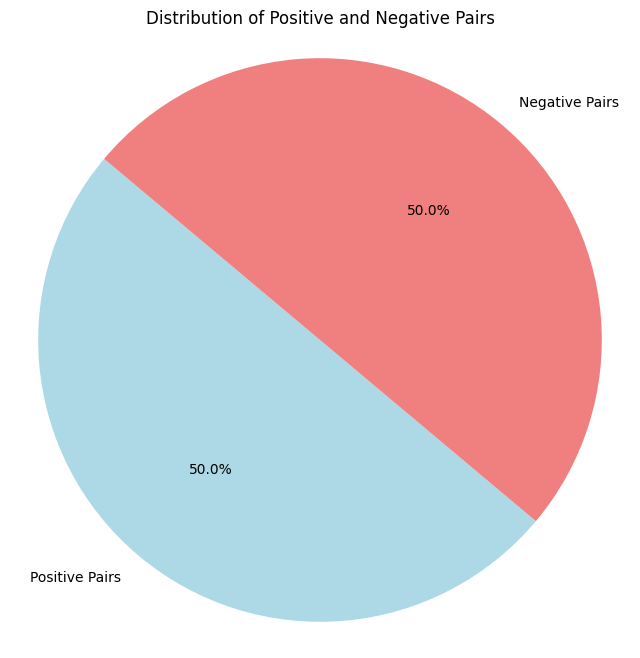

In [ ]:
def create_pie_chart(labels):
    # Count the number of positive and negative pairs
    num_positive_pairs = sum(labels)
    num_negative_pairs = len(labels) - num_positive_pairs

    # Data for pie chart
    sizes = [num_positive_pairs, num_negative_pairs]
    labels = ['Positive Pairs', 'Negative Pairs']
    colors = ['lightblue', 'lightcoral']

    # Create pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.title('Distribution of Positive and Negative Pairs')
    plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular
    plt.show()
create_pie_chart(labels)

In [ ]:
reduced_postive_pairs = pairs[:10000]
reduced_negative_pairs = pairs[1637114:1647114]
reduced_positive_labels = labels[:1000]
reduced_negative_labels = labels[1637114:1647114]
reduced_pairs = reduced_postive_pairs + reduced_negative_pairs
reduced_labels = reduced_positive_labels + reduced_negative_labels

## DATA VISUALIZATIONS

**Before Preprocessing**

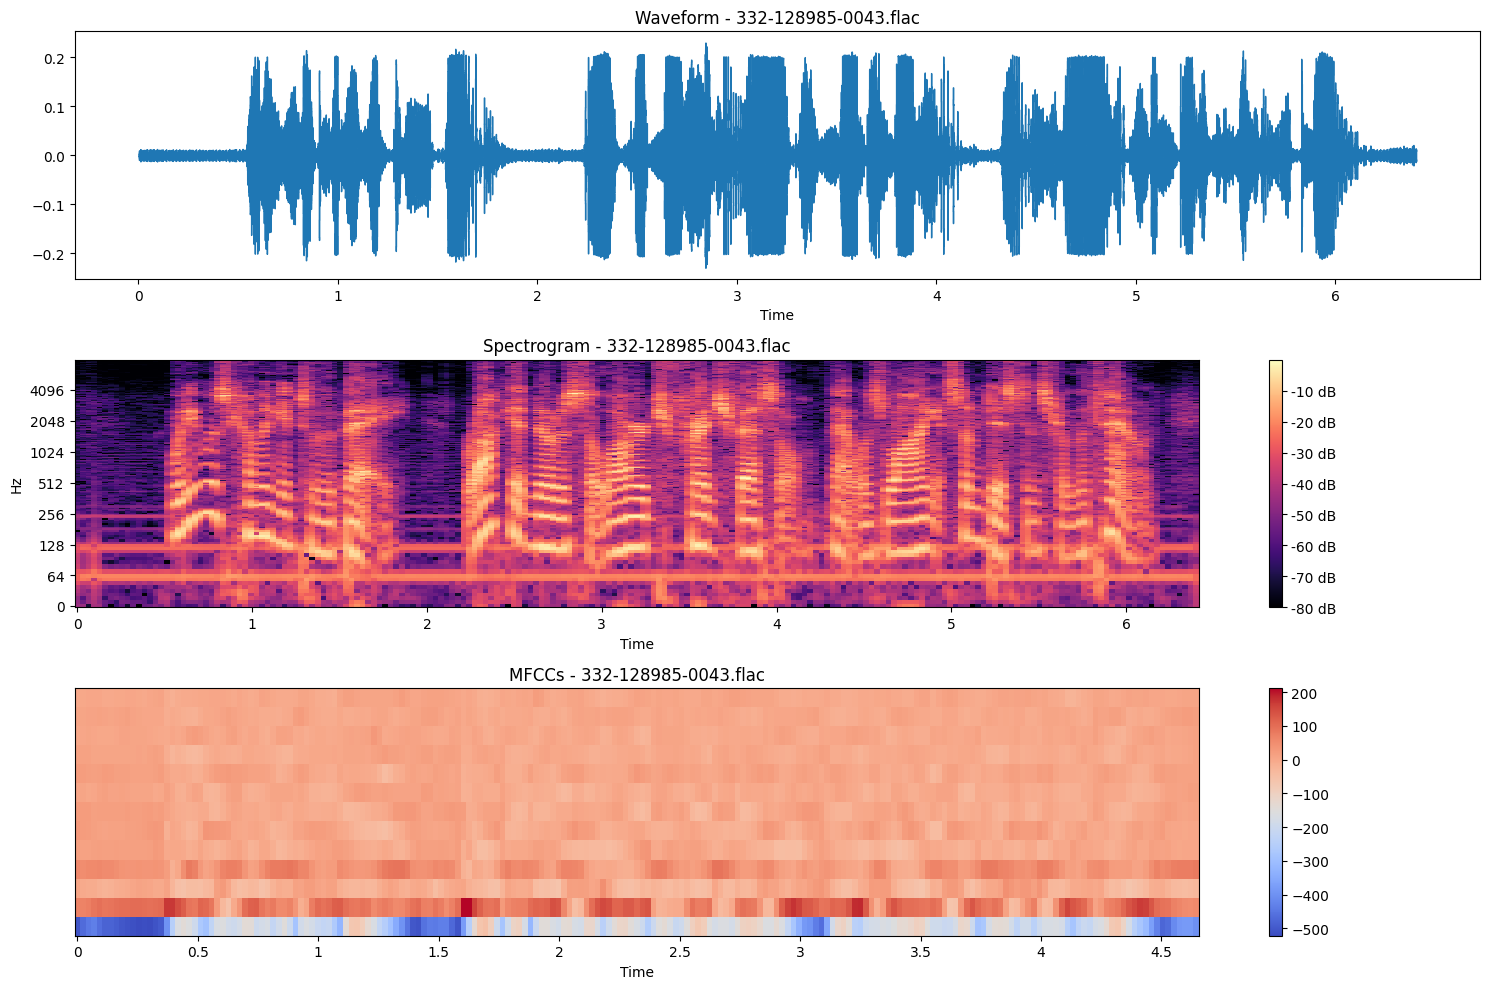

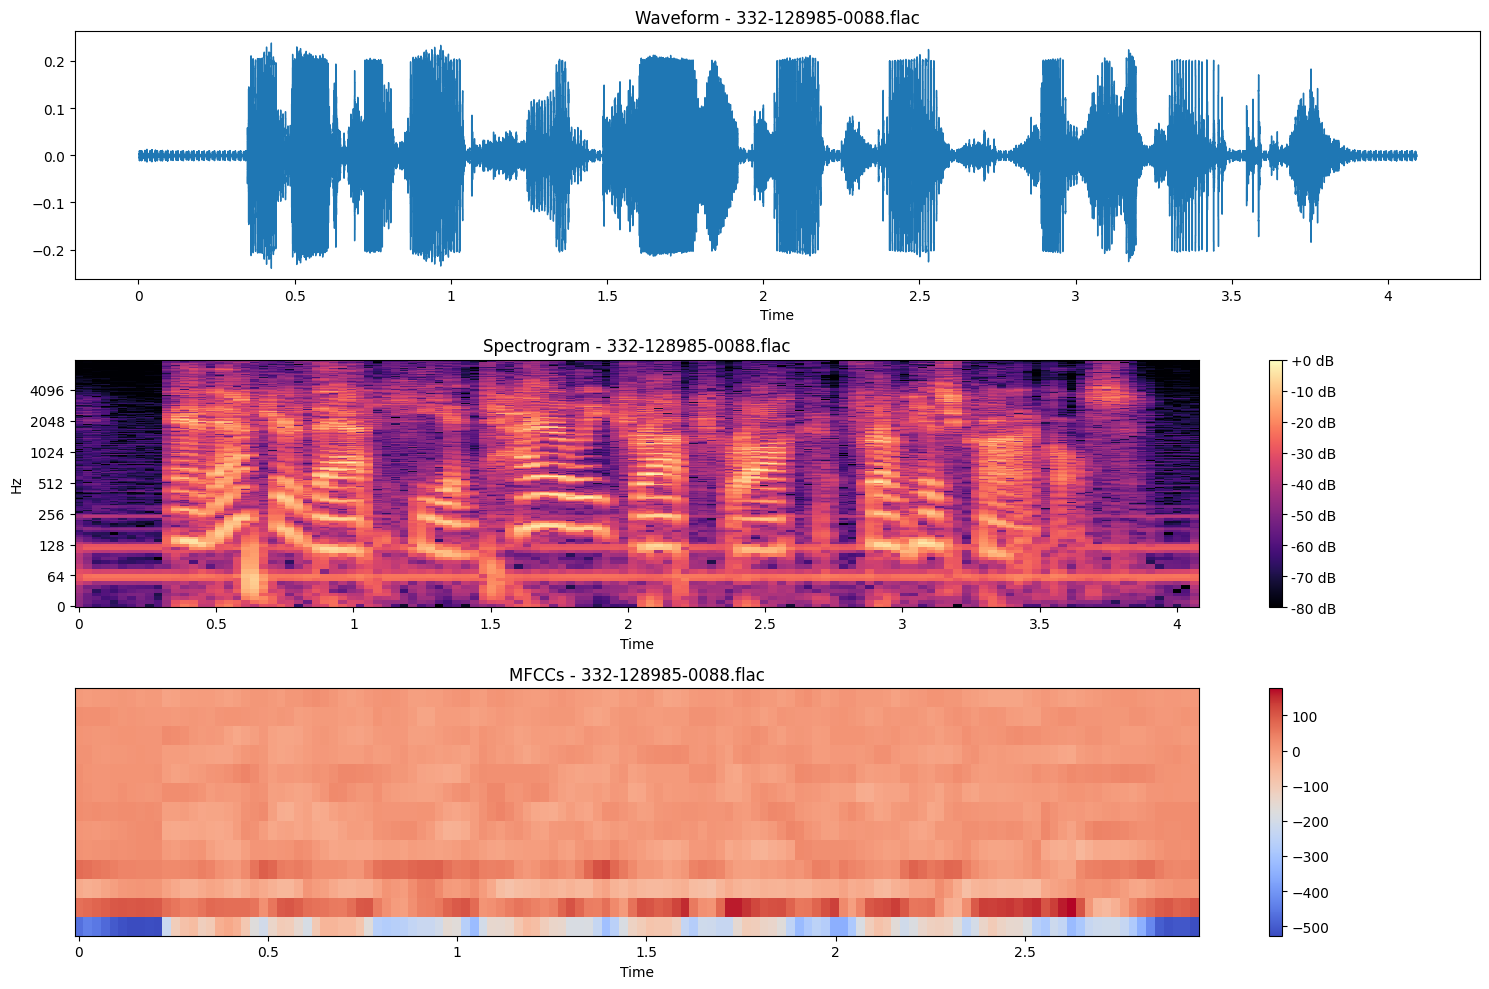

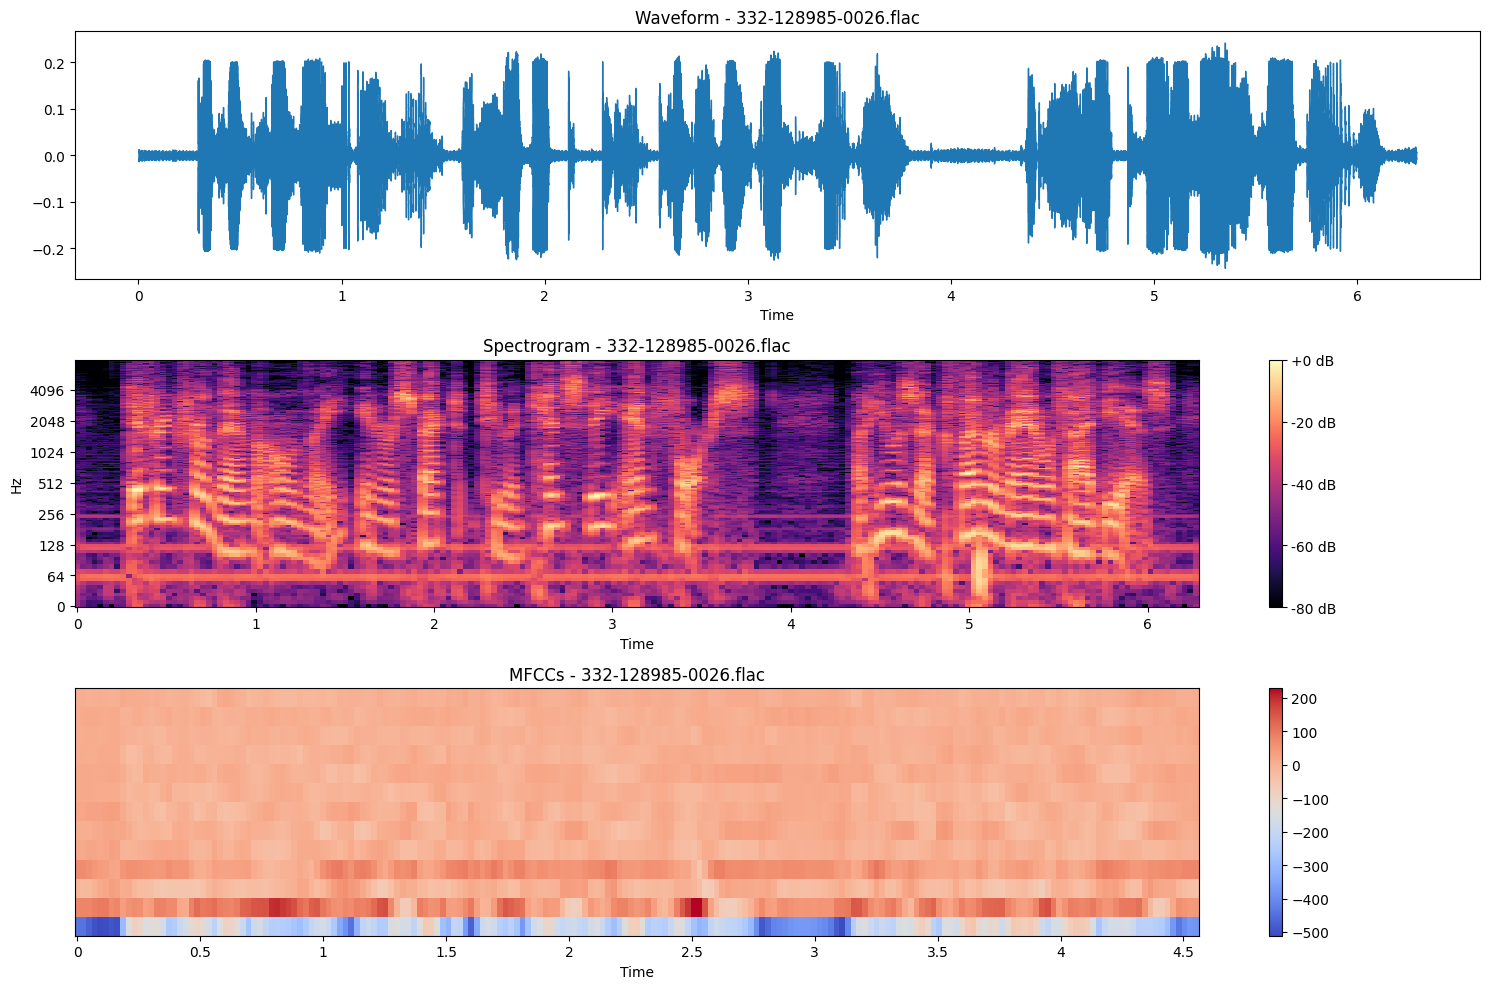

In [ ]:
# Function to plot the waveform, spectrogram, and MFCCs
def plot_audio_features(audio_path):
    # Load audio file
    y, sr = librosa.load(audio_path, sr=None)

    # Extract speaker name from the file path
    speaker_name = os.path.basename(audio_path).split('_')[0]

    # Plot the waveform
    plt.figure(figsize=(15, 10))
    plt.subplot(3, 1, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f'Waveform - {speaker_name}')

    # Plot the spectrogram
    plt.subplot(3, 1, 2)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram - {speaker_name}')

    # Plot the MFCCs
    plt.subplot(3, 1, 3)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    librosa.display.specshow(mfccs, x_axis='time')
    plt.colorbar()
    plt.title(f'MFCCs - {speaker_name}')

    plt.tight_layout()
    plt.show()

# Plot features for each audio file
for audio_path in df['audio_path'][:3]:
  if audio_path.endswith('.flac'):
    plot_audio_features(audio_path)

**After Preprocessing**

In [ ]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(np.array(audios[100].cpu()),sr=rate)
plt.show()

In [ ]:
frequencies, times, spectrogram = signal.spectrogram(audios[100].cpu(), rate)
spectrogram = 10 * np.log10(spectrogram)

plt.imshow(spectrogram, aspect='auto', origin='lower', cmap='jet')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.show()

## DATA PREPROCESSING

In [ ]:
DATASET_AUDIO_PATH = "dataset-speaker-recognition-librispeech/LibriSpeech/dev-clean"

In [ ]:
DATASET_AUDIO_PATH = "dataset-speaker-recognition-librispeech/LibriSpeech/train-clean-100"

In [ ]:
# rate = 16000
# clip_duration = 1.4

# # Utiliser le DataFrame existant pour obtenir les chemins des fichiers audio
# audio_paths = df['audio_path'].tolist()

# # Create empty lists for audios and labels
# audios = []
# labels = []

# # Iterate over the audio files
# for file_path in tqdm(audio_paths[0:100]):
#     data, samplerate = sf.read(file_path)

#     # Divide data into 5-second clips
#     step = rate * clip_duration
#     for i in np.arange(0, len(data), step):
#         if i + step > len(data):
#             break
#         start = int(i)
#         stop = int(i + step)
#         audio_clip = torch.tensor(data[start:stop]).to(device)

#         audios.append(audio_clip)
#         # Assuming you have a column named 'speaker_name' in your DataFrame
#         # Use it to map to the corresponding label
#         label = file_path.split('/')[3]
#         label = int(label)
#         labels.append(label)

# # Convert audios and labels to PyTorch tensors
# audios = torch.stack(audios).to(device)
# labels = torch.tensor(labels).to(device)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
rate=16000
clip_duration=1.4

class_names = os.listdir(DATASET_AUDIO_PATH)

# Create empty lists for audios and labels
audios = []
labels = []

# Iterate over the audio files
for name in tqdm(class_names):
    dir_path = Path(DATASET_AUDIO_PATH) / name
    name=int(name)
    for filepath in os.listdir(dir_path):
        for innerfile in os.listdir(os.path.join(dir_path, filepath)):
            if innerfile.endswith(".flac"):
                file_path = PurePath(os.path.join(dir_path, filepath, innerfile))
                data, samplerate = sf.read(file_path)

                # Divide data into 5-second clips
                step = rate * clip_duration
                for i in np.arange(0, len(data), step):
                    if i + step > len(data):
                        break
                    start = int(i)
                    stop = int(i + step)
                    # audio_clip = torch.tensor(data[start:stop]).to(device)
                    audio_clip = torch.tensor(data[start:stop])

                    audios.append(audio_clip)
                    labels.append(name)

# Convert audios and labels to PyTorch tensors
audios = torch.stack(audios).to(device)
labels = torch.tensor(labels).to(device)
print(len(audios),len(labels))

In [ ]:
rate = 16000
clip_duration = 1.4
max_audios_per_class = 100

class_names = os.listdir(DATASET_AUDIO_PATH)

# Create empty lists for audios and labels
audios = []
labels = []
audios_per_class = {}

# Iterate over the audio files
for name in tqdm(class_names):
    dir_path = Path(DATASET_AUDIO_PATH) / name
    name = int(name)
    audios_added = 0
    for filepath in os.listdir(dir_path):
        for innerfile in os.listdir(os.path.join(dir_path, filepath)):
            if innerfile.endswith(".flac"):
                if audios_added >= max_audios_per_class:
                    break
                file_path = PurePath(os.path.join(dir_path, filepath, innerfile))
                data, samplerate = sf.read(file_path)

                # Divide data into 1.4-second clips
                step = int(rate * clip_duration)
                for i in np.arange(0, len(data), step):
                    if i + step > len(data):
                        break
                    start = int(i)
                    stop = int(i + step)
                    audio_clip = torch.tensor(data[start:stop])

                    audios.append(audio_clip)
                    labels.append(name)
                    audios_added += 1
                    if audios_added >= max_audios_per_class:
                        break
    audios_per_class[name] = min(audios_added, max_audios_per_class)

# Convert audios and labels to PyTorch tensors
audios = torch.stack(audios)
labels = torch.tensor(labels)

print("Nombre total d'audios :", len(audios))
print("Nombre total d'étiquettes :", len(labels))
print("Nombre d'audios par classe :", audios_per_class)

  0%|          | 0/251 [00:00<?, ?it/s]

Nombre total d'audios : 25100
Nombre total d'étiquettes : 25100
Nombre d'audios par classe : {332: 100, 250: 100, 6081: 100, 1363: 100, 4680: 100, 4018: 100, 7859: 100, 1553: 100, 2289: 100, 3526: 100, 6454: 100, 4340: 100, 1898: 100, 4441: 100, 5322: 100, 1334: 100, 6563: 100, 4397: 100, 4898: 100, 6272: 100, 7190: 100, 7264: 100, 3436: 100, 5778: 100, 7278: 100, 8238: 100, 6064: 100, 302: 100, 8747: 100, 8580: 100, 211: 100, 6529: 100, 8629: 100, 839: 100, 5049: 100, 625: 100, 60: 100, 7517: 100, 198: 100, 1737: 100, 2764: 100, 4481: 100, 1081: 100, 3242: 100, 3374: 100, 19: 100, 1235: 100, 6000: 100, 909: 100, 8630: 100, 3214: 100, 8465: 100, 1963: 100, 7302: 100, 5703: 100, 5393: 100, 5652: 100, 5192: 100, 3235: 100, 2514: 100, 6415: 100, 1624: 100, 8425: 100, 6019: 100, 2989: 100, 445: 100, 481: 100, 163: 100, 1594: 100, 3983: 100, 412: 100, 2952: 100, 3807: 100, 8419: 100, 5678: 100, 7178: 100, 4362: 100, 3112: 100, 5463: 100, 200: 100, 328: 100, 226: 100, 1246: 100, 5688: 100, 7

In [ ]:
audios[:3]

tensor([[ 0.0020,  0.0016,  0.0016,  ..., -0.0080, -0.0083, -0.0098],
        [-0.0117, -0.0142, -0.0151,  ..., -0.0029, -0.0092, -0.0209],
        [-0.0331, -0.0390, -0.0352,  ...,  0.0230,  0.0197,  0.0201]],
       dtype=torch.float64)

In [ ]:
labels[:3]

tensor([2902, 2902, 2902])

In [ ]:
# play audio from array
print(labels[100])
Audio(audios[100].cpu(), rate=rate)

tensor(2902)


In [ ]:
print(labels[500])
Audio(audios[500].cpu(), rate=rate)

tensor(2277)


In [ ]:
# compute MFCCs
# Define parameters for preprocessing
sr = rate # Sampling rate
n_mfcc = 13 # Number of Mel frequency cepstral coefficients (MFCCs)
n_fft = 2048 # FFT window size
hop_length = 512 # Hop length for FFT
def compute_mfcc(audio):

    # Preprocess audio samples using librosa
    return np.expand_dims(librosa.feature.mfcc(y=np.array(audio.cpu()), sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length).T, axis=0)

In [ ]:
mfcc=compute_mfcc(audios[100])
mfcc.shape

(1, 44, 13)

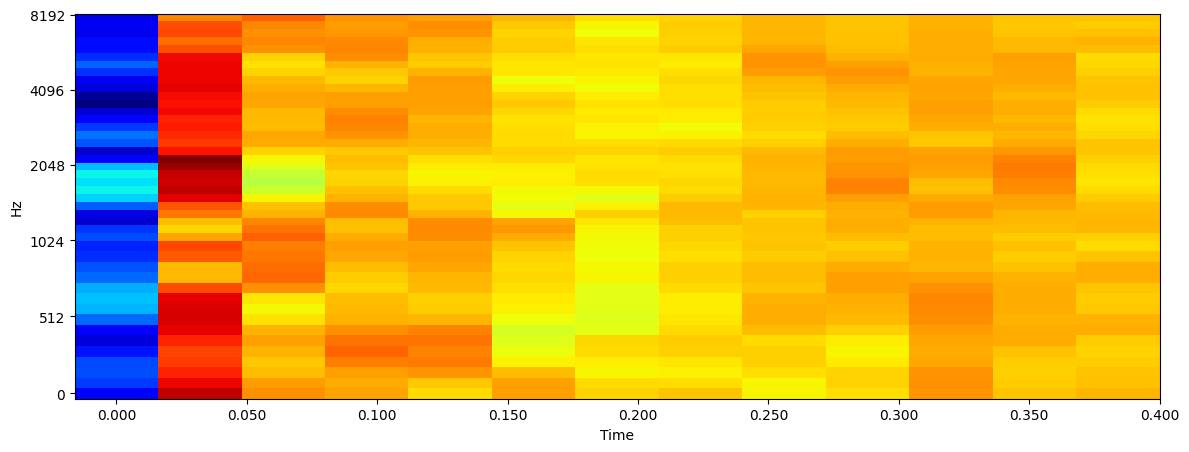

In [ ]:
# visualize MFCCs
plt.figure(figsize=(14, 5))
librosa.display.specshow(mfcc[0], sr=rate, x_axis='time', cmap='jet',y_axis='mel')
plt.show()

In [ ]:
not_normlised=[compute_mfcc(audio) for audio in tqdm(audios)]
not_normlised=np.array(not_normlised)

  0%|          | 0/25100 [00:00<?, ?it/s]

In [ ]:
not_normlised.shape

(25100, 1, 44, 13)

In [ ]:
not_normlised[0]

array([[[-4.99132592e+02,  8.39237353e+01, -1.48535309e+01,
          1.60124463e+01,  5.20228890e+00, -1.12256384e+01,
         -2.28181291e-01,  3.40702042e+00,  8.11156601e+00,
         -1.09578365e+01, -1.13740150e+01,  1.45754681e+01,
          3.73634666e+00],
        [-4.74922418e+02,  9.22725007e+01, -1.69549607e+01,
          1.91924202e+01, -4.08446755e+00, -9.93852354e+00,
          2.79890177e+00, -1.77616109e+00,  8.01046384e+00,
         -9.58875689e+00, -8.71184092e+00,  1.36803993e+01,
          1.00761166e+00],
        [-4.80057454e+02,  8.83879842e+01, -1.61217310e+01,
          1.86677702e+01, -4.50999880e+00, -1.05420133e+01,
         -3.34535171e-01, -3.88739028e+00,  5.21198517e+00,
         -1.06300840e+01, -8.02717124e+00,  1.37845482e+01,
          7.21994787e-01],
        [-4.82626882e+02,  8.95147146e+01, -1.42859857e+01,
          1.76467712e+01, -6.73659701e-01, -5.25519097e+00,
         -1.33293811e+00, -6.55062731e+00,  3.18345157e+00,
         -1.6565983

In [ ]:
not_normlised.shape[-1]

13

In [ ]:
not_normlised.shape

(25100, 1, 44, 13)

In [ ]:
not_normlised.reshape(-1, not_normlised.shape[-1]).shape

(1104400, 13)

In [ ]:
# minMaxScaler for MFCCs
scaler = MinMaxScaler()
scaler.fit(not_normlised.reshape(-1, not_normlised.shape[-1]))
normlised = scaler.transform(not_normlised.reshape(-1, not_normlised.shape[-1])).reshape(not_normlised.shape)

In [ ]:
# transform audios to mfcc
audios = torch.tensor(normlised).float().to(device)

In [ ]:
# Définir les paramètres de prétraitement
sr = 16000  # Taux d'échantillonnage
n_mfcc = 13  # Nombre de coefficients MFCC
n_fft = 2048  # Taille de la fenêtre FFT
hop_length = 512  # Longueur du saut pour la FFT
clip_duration=1.4

def preprocess_audio(audio,scaler):
    sr = 16000 # Sampling rate
    n_mfcc = 13 # Number of Mel frequency cepstral coefficients (MFCCs)
    n_fft = 2048 # FFT window size
    hop_length = 512 # Hop length for FFT

    # Preprocess audio samples using librosa
    data, samplerate = sf.read(file_path)

                # Divide data into 5-second clips
    step = rate * clip_duration
    for i in np.arange(0, len(data), step):
      if i + step > len(data):
        break
        start = int(i)
        stop = int(i + step)
        audio_clip = torch.tensor(data[start:stop]).to(device)
        not_normlised = np.expand_dims(librosa.feature.mfcc(y=np.array(audio_clip.cpu()), sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length).T, axis=0)
        normalized = not_normlised.reshape(-1, not_normlised.shape[-1]).shape
        scaler.fit(not_normlised.reshape(-1, not_normlised.shape[-1]))
        normlised = scaler.transform(not_normlised.reshape(-1, not_normlised.shape[-1])).reshape(not_normlised.shape)
        preprocessed_audio= torch.tensor(normlised).float().to(device)

        return preprocessed_audio

In [ ]:
# save scaler
import pickle
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [ ]:
def create_pairs(label_ids):
    label_ids = np.array(label_ids.cpu())
    pairs = []
    labels = []
    n_classes = len(np.unique(label_ids))
    n_pairs_per_class = min(50, len(label_ids)//n_classes)

    idx = [np.where(label_ids == i)[0] for i in range(n_classes)]
    for t, idx1 in enumerate(idx):
        # Choose indices for positive pairs
        idx1_1 = np.random.choice(idx1, size=n_pairs_per_class, replace=len(idx1) < n_pairs_per_class)
        for i, idx_i in enumerate(idx1_1):
            # Positive pairs
            for j in idx1[idx1 != idx_i]:
                pairs.append([idx_i, j])
                labels.append(1)
            # Negative pairs
            other_classes = np.delete(idx, t, axis=0)
            for _ in range(n_pairs_per_class):
                k = np.random.randint(0, len(other_classes))
                idx2 = np.random.choice(other_classes[k], size=1)
                pairs.append([idx_i, idx2[0]])
                labels.append(0)

    return torch.tensor(pairs), torch.tensor(labels)

In [ ]:
# make labels sequential from 0 to n
label_to_index = {}
labels_numpy=np.array(labels.cpu())
for label in labels_numpy:
    if label not in label_to_index:
        label_to_index[label] = len(label_to_index)

# convert labels to index
label_ids = np.array([label_to_index[x] for x in labels_numpy])
label_ids = torch.tensor(label_ids).to(device)

In [ ]:
pairs,y = create_pairs(label_ids)

In [ ]:
shuffle_index = np.arange(len(pairs))
np.random.shuffle(shuffle_index)
pairs = torch.tensor(np.array(pairs.cpu())[shuffle_index]).to(device)
y = torch.tensor(np.array(y.cpu())[shuffle_index]).float().to(device)

print("Number of pairs:", len(pairs))
print("Number of positive pairs:", (y == 1).sum().item())
print("Number of negative pairs:", (y == 0).sum().item())

Number of pairs: 2484900
Number of positive pairs: 1242450
Number of negative pairs: 1242450


In [ ]:
# Comptage des paires positives et négatives
num_positive_pairs = (y == 1).sum().item()
num_negative_pairs = (y == 0).sum().item()

# Si le nombre de paires positives est supérieur au nombre de paires négatives, réduisez les paires positives
if num_positive_pairs > num_negative_pairs:
    positive_indices = (y == 1).nonzero(as_tuple=True)[0]
    negative_indices = (y == 0).nonzero(as_tuple=True)[0]

    # Sélectionner un sous-ensemble aléatoire des paires positives
    selected_positive_indices = np.random.choice(positive_indices.cpu(), size=num_negative_pairs, replace=False)

    # Combiner les indices sélectionnés
    combined_indices = np.concatenate((selected_positive_indices, negative_indices.cpu()))
else:
    combined_indices = np.arange(len(pairs))

# Mélanger les indices combinés
np.random.shuffle(combined_indices)

# Sélectionner les paires et les labels selon les indices combinés
pairs = pairs[combined_indices]
y = y[combined_indices]

print("Number of pairs:", len(pairs))
print("Number of positive pairs:", (y == 1).sum().item())
print("Number of negative pairs:", (y == 0).sum().item())

Number of pairs: 1255000
Number of positive pairs: 627500
Number of negative pairs: 627500


**Solution**

In [ ]:
import torch
import numpy as np
from tqdm import tqdm

def create_pairs(label_ids):
    label_ids = np.array(label_ids.cpu())
    pairs = []
    labels = []
    n_classes = len(np.unique(label_ids))
    n_pairs_per_class = min(50, len(label_ids) // n_classes)  # Ajustez cette valeur si nécessaire

    idx = [np.where(label_ids == i)[0] for i in range(n_classes)]

    # Créer des paires positives et négatives équilibrées
    positive_pairs = []
    negative_pairs = []

    for t, idx1 in enumerate(idx):
        # Choisir des indices pour les paires positives
        for i in range(len(idx1)):
            for j in range(i + 1, len(idx1)):
                positive_pairs.append([idx1[i], idx1[j]])

        # Choisir des indices pour les paires négatives
        for i in idx1:
            other_classes_indices = np.hstack([idx[k] for k in range(n_classes) if k != t])
            neg_indices = np.random.choice(other_classes_indices, size=n_pairs_per_class, replace=len(other_classes_indices) < n_pairs_per_class)
            for neg in neg_indices:
                negative_pairs.append([i, neg])

    # Assurez l'équilibre des paires positives et négatives
    min_pairs = min(len(positive_pairs), len(negative_pairs))
    selected_positive_pairs = np.random.choice(len(positive_pairs), size=min_pairs, replace=False)
    selected_negative_pairs = np.random.choice(len(negative_pairs), size=min_pairs, replace=False)

    for idx in selected_positive_pairs:
        pairs.append(positive_pairs[idx])
        labels.append(1)

    for idx in selected_negative_pairs:
        pairs.append(negative_pairs[idx])
        labels.append(0)

    pairs = np.array(pairs)
    labels = np.array(labels)

    # Mélanger les paires
    shuffle_indices = np.random.permutation(len(pairs))
    pairs = pairs[shuffle_indices]
    labels = labels[shuffle_indices]

    return torch.tensor(pairs).to(device), torch.tensor(labels).to(device)

In [ ]:
audios.shape

torch.Size([12500, 1, 44, 13])

In [ ]:
pairs.shape,y.shape

(torch.Size([381000, 2]), torch.Size([381000]))

In [ ]:
def create_pie_chart(labels):
    # Count the number of positive and negative pairs
    num_positive_pairs = torch.sum(y == 1).item()
    num_negative_pairs = torch.sum(y == 0).item()

    # Data for pie chart
    sizes = [num_positive_pairs, num_negative_pairs]
    labels = ['Positive Pairs', 'Negative Pairs']
    colors = ['#f8b800', '#e7553c']

    # Create pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.title('Distribution of Positive and Negative Pairs')
    plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular
    plt.show()

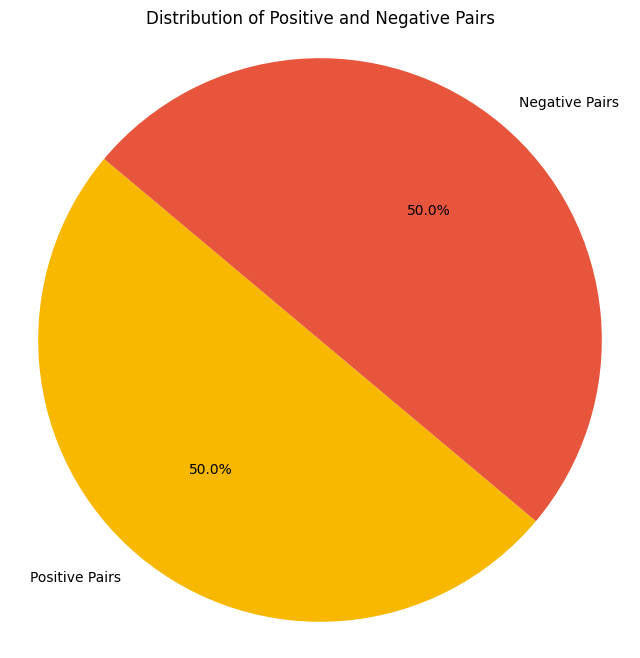

In [ ]:
create_pie_chart(y)

## MODEL SET UP - TRAIN/TEST SPLIT AND EVALUATION

In [ ]:
# Define the Siamese network architecture in PyTorch
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.embedding_layer = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(64 * 9* 1, 16),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.embedding_layer(x)
        return x

In [ ]:
# Define the Siamese model in PyTorch
class SiameseModel(nn.Module):
    def __init__(self, siamese_network):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.fc = nn.Linear(16, 1)

    def forward(self,x1, x2):
        embedding_1 = self.siamese_network(x1)
        embedding_2 = self.siamese_network(x2)
#         output  = F.cosine_similarity(embedding_1, embedding_2)
        output = torch.abs(embedding_1 - embedding_2)  # Absolute difference
        output = self.fc(output)
        output = torch.sigmoid(output)  # Apply sigmoid activation for binary classification
        return output.squeeze()

In [ ]:
# Convert the data generator into a PyTorch dataset
class Dataset(Dataset):
    def __init__(self, X, pairs, y):
        self.X = X
        self.pairs = pairs
        self.y = y

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, index):
        pair = self.pairs[index]
        x1 = self.X[pair[0]]
        x2 = self.X[pair[1]]
        y = self.y[index]
        return x1, x2, y

In [ ]:
# Create an instance of the Siamese network in PyTorch
siamese_network_pt = SiameseNetwork()

# Create an instance of the Siamese model in PyTorch
model = SiameseModel(siamese_network_pt).to(device)

# Define the loss function and optimizer
criterion = nn.BCELoss()
# criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
summary(model, [audios.shape[1:],audios.shape[1:]])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 42, 11]             320
              ReLU-2           [-1, 32, 42, 11]               0
         MaxPool2d-3            [-1, 32, 21, 5]               0
            Conv2d-4            [-1, 64, 19, 3]          18,496
              ReLU-5            [-1, 64, 19, 3]               0
         MaxPool2d-6             [-1, 64, 9, 1]               0
           Flatten-7                  [-1, 576]               0
           Dropout-8                  [-1, 576]               0
            Linear-9                   [-1, 16]           9,232
             ReLU-10                   [-1, 16]               0
   SiameseNetwork-11                   [-1, 16]               0
           Conv2d-12           [-1, 32, 42, 11]             320
             ReLU-13           [-1, 32, 42, 11]               0
        MaxPool2d-14            [-1, 32

In [ ]:
# Convert the data generator into a PyTorch data loader
batch_size = 32
dataset = Dataset(audios, pairs, y)
# data_loader = DataLoader(dataset, batch_size=batch_size,shuffle=True)

**Train Test Split Dataset**

In [ ]:
# Split the dataset indices into train, validation, and test sets
train_indices, temp_indices = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=42)
val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=42)

# Create subset datasets
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# Define batch size
batch_size = 64

# Create DataLoader objects for each subset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Number of training batches:", len(train_loader))
print("Number of validation batches:", len(val_loader))
print("Number of testing batches:", len(test_loader))

Number of training batches: 31062
Number of validation batches: 3883
Number of testing batches: 3883


## TRAINING

In [ ]:
def training_loop(train_loader,val_loader,model,num_epochs=10):
  # Initialiser les listes pour stocker les métriques
  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []

  # Boucle d'entraînement
  for epoch in range(num_epochs):
      # Variables pour les métriques d'entraînement
      total_train_loss = 0.0
      total_train_correct = 0
      total_train_samples = 0

      with tqdm(train_loader, unit="batch") as t:
          t.set_description(f"Epoch {epoch+1}/{num_epochs}")
          for batch in t:
              x1, x2, label = batch

              optimizer.zero_grad()
              output = model(x1, x2)
              loss = criterion(output, label)
              loss.backward()
              optimizer.step()

              # Mettre à jour les statistiques
              total_train_loss += loss.item() * label.size(0)
              predictions = (output > 0.5).long()
              total_train_correct += (predictions == label).sum().item()
              total_train_samples += label.size(0)

              # Calculer la précision
              train_accuracy = total_train_correct / total_train_samples

              # Mettre à jour la description de la barre de progression
              t.set_postfix(loss=total_train_loss / total_train_samples, accuracy=train_accuracy)

      # Calculer et stocker les métriques d'entraînement de l'époque
      epoch_train_loss = total_train_loss / total_train_samples
      epoch_train_accuracy = train_accuracy
      train_losses.append(epoch_train_loss)
      train_accuracies.append(epoch_train_accuracy)

      # Évaluation sur l'ensemble de validation
      model.eval()
      total_val_loss = 0.0
      total_val_correct = 0
      total_val_samples = 0
      with torch.no_grad():
          for batch in val_loader:
              x1, x2, label = batch
              output = model(x1, x2)
              loss = criterion(output, label)

              # Mettre à jour les statistiques de validation
              total_val_loss += loss.item() * label.size(0)
              predictions = (output > 0.5).long()
              total_val_correct += (predictions == label).sum().item()
              total_val_samples += label.size(0)

      # Calculer et stocker les métriques de validation de l'époque
      epoch_val_loss = total_val_loss / total_val_samples
      epoch_val_accuracy = total_val_correct / total_val_samples
      val_losses.append(epoch_val_loss)
      val_accuracies.append(epoch_val_accuracy)

      # Imprimer le résumé de l'époque
      print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}")

      # Sauvegarder le modèle
      torch.save(model.state_dict(), f"model_epoch_{epoch+1}.pt")

  # Retourner les listes de métriques
  return train_losses, train_accuracies, val_losses, val_accuracies


In [ ]:
train_losses, train_accuracies, val_losses, val_accuracies = training_loop(train_loader,val_loader,model,num_epochs=30)

Epoch 1/30: 100%|██████████| 31062/31062 [04:57<00:00, 104.37batch/s, accuracy=0.709, loss=0.547]


Epoch [1/30], Train Loss: 0.5466, Train Accuracy: 0.7088, Val Loss: 0.5536, Val Accuracy: 0.6914


Epoch 2/30: 100%|██████████| 31062/31062 [04:36<00:00, 112.29batch/s, accuracy=0.818, loss=0.409]


Epoch [2/30], Train Loss: 0.4087, Train Accuracy: 0.8177, Val Loss: 0.3674, Val Accuracy: 0.8390


Epoch 3/30: 100%|██████████| 31062/31062 [04:35<00:00, 112.74batch/s, accuracy=0.85, loss=0.348]


Epoch [3/30], Train Loss: 0.3479, Train Accuracy: 0.8498, Val Loss: 0.3314, Val Accuracy: 0.8587


Epoch 4/30: 100%|██████████| 31062/31062 [04:35<00:00, 112.64batch/s, accuracy=0.868, loss=0.312]


Epoch [4/30], Train Loss: 0.3122, Train Accuracy: 0.8685, Val Loss: 0.2989, Val Accuracy: 0.8748


Epoch 5/30: 100%|██████████| 31062/31062 [04:35<00:00, 112.66batch/s, accuracy=0.88, loss=0.289]


Epoch [5/30], Train Loss: 0.2886, Train Accuracy: 0.8801, Val Loss: 0.2832, Val Accuracy: 0.8833


Epoch 6/30: 100%|██████████| 31062/31062 [04:35<00:00, 112.82batch/s, accuracy=0.888, loss=0.272]


Epoch [6/30], Train Loss: 0.2725, Train Accuracy: 0.8878, Val Loss: 0.2667, Val Accuracy: 0.8902


Epoch 7/30: 100%|██████████| 31062/31062 [04:34<00:00, 113.16batch/s, accuracy=0.893, loss=0.261]


Epoch [7/30], Train Loss: 0.2614, Train Accuracy: 0.8929, Val Loss: 0.2565, Val Accuracy: 0.8949


Epoch 8/30: 100%|██████████| 31062/31062 [04:34<00:00, 113.00batch/s, accuracy=0.897, loss=0.253]


Epoch [8/30], Train Loss: 0.2534, Train Accuracy: 0.8965, Val Loss: 0.2556, Val Accuracy: 0.8946


Epoch 9/30: 100%|██████████| 31062/31062 [04:35<00:00, 112.68batch/s, accuracy=0.899, loss=0.248]


Epoch [9/30], Train Loss: 0.2475, Train Accuracy: 0.8991, Val Loss: 0.2449, Val Accuracy: 0.9001


Epoch 10/30: 100%|██████████| 31062/31062 [04:35<00:00, 112.61batch/s, accuracy=0.901, loss=0.243]


Epoch [10/30], Train Loss: 0.2428, Train Accuracy: 0.9013, Val Loss: 0.2431, Val Accuracy: 0.9009


Epoch 11/30: 100%|██████████| 31062/31062 [04:34<00:00, 113.09batch/s, accuracy=0.903, loss=0.239]


Epoch [11/30], Train Loss: 0.2390, Train Accuracy: 0.9030, Val Loss: 0.2387, Val Accuracy: 0.9030


Epoch 12/30: 100%|██████████| 31062/31062 [04:35<00:00, 112.85batch/s, accuracy=0.905, loss=0.235]


Epoch [12/30], Train Loss: 0.2355, Train Accuracy: 0.9046, Val Loss: 0.2408, Val Accuracy: 0.9018


Epoch 13/30: 100%|██████████| 31062/31062 [04:36<00:00, 112.31batch/s, accuracy=0.906, loss=0.232]


Epoch [13/30], Train Loss: 0.2325, Train Accuracy: 0.9060, Val Loss: 0.2357, Val Accuracy: 0.9037


Epoch 14/30: 100%|██████████| 31062/31062 [04:36<00:00, 112.53batch/s, accuracy=0.907, loss=0.23]


Epoch [14/30], Train Loss: 0.2298, Train Accuracy: 0.9072, Val Loss: 0.2294, Val Accuracy: 0.9070


Epoch 15/30: 100%|██████████| 31062/31062 [04:37<00:00, 112.12batch/s, accuracy=0.908, loss=0.227]


Epoch [15/30], Train Loss: 0.2273, Train Accuracy: 0.9084, Val Loss: 0.2273, Val Accuracy: 0.9081


Epoch 16/30: 100%|██████████| 31062/31062 [04:36<00:00, 112.36batch/s, accuracy=0.909, loss=0.225]


Epoch [16/30], Train Loss: 0.2248, Train Accuracy: 0.9094, Val Loss: 0.2253, Val Accuracy: 0.9089


Epoch 17/30: 100%|██████████| 31062/31062 [04:36<00:00, 112.51batch/s, accuracy=0.911, loss=0.222]


Epoch [17/30], Train Loss: 0.2223, Train Accuracy: 0.9107, Val Loss: 0.2311, Val Accuracy: 0.9070


Epoch 18/30: 100%|██████████| 31062/31062 [04:36<00:00, 112.35batch/s, accuracy=0.912, loss=0.22]


Epoch [18/30], Train Loss: 0.2197, Train Accuracy: 0.9119, Val Loss: 0.2206, Val Accuracy: 0.9114


Epoch 19/30: 100%|██████████| 31062/31062 [04:36<00:00, 112.36batch/s, accuracy=0.913, loss=0.218]


Epoch [19/30], Train Loss: 0.2175, Train Accuracy: 0.9128, Val Loss: 0.2177, Val Accuracy: 0.9129


Epoch 20/30: 100%|██████████| 31062/31062 [04:38<00:00, 111.42batch/s, accuracy=0.914, loss=0.216]


Epoch [20/30], Train Loss: 0.2156, Train Accuracy: 0.9138, Val Loss: 0.2155, Val Accuracy: 0.9133


Epoch 21/30: 100%|██████████| 31062/31062 [04:36<00:00, 112.25batch/s, accuracy=0.914, loss=0.214]


Epoch [21/30], Train Loss: 0.2137, Train Accuracy: 0.9144, Val Loss: 0.2152, Val Accuracy: 0.9137


Epoch 22/30: 100%|██████████| 31062/31062 [04:34<00:00, 113.08batch/s, accuracy=0.915, loss=0.212]


Epoch [22/30], Train Loss: 0.2120, Train Accuracy: 0.9153, Val Loss: 0.2154, Val Accuracy: 0.9133


Epoch 23/30: 100%|██████████| 31062/31062 [04:35<00:00, 112.90batch/s, accuracy=0.916, loss=0.21]


Epoch [23/30], Train Loss: 0.2104, Train Accuracy: 0.9162, Val Loss: 0.2132, Val Accuracy: 0.9146


Epoch 24/30: 100%|██████████| 31062/31062 [04:34<00:00, 113.06batch/s, accuracy=0.917, loss=0.209]


Epoch [24/30], Train Loss: 0.2089, Train Accuracy: 0.9167, Val Loss: 0.2102, Val Accuracy: 0.9156


Epoch 25/30: 100%|██████████| 31062/31062 [04:35<00:00, 112.87batch/s, accuracy=0.918, loss=0.207]


Epoch [25/30], Train Loss: 0.2073, Train Accuracy: 0.9176, Val Loss: 0.2093, Val Accuracy: 0.9164


Epoch 26/30: 100%|██████████| 31062/31062 [04:35<00:00, 112.90batch/s, accuracy=0.918, loss=0.206]


Epoch [26/30], Train Loss: 0.2059, Train Accuracy: 0.9183, Val Loss: 0.2084, Val Accuracy: 0.9173


Epoch 27/30: 100%|██████████| 31062/31062 [04:31<00:00, 114.38batch/s, accuracy=0.919, loss=0.205]


Epoch [27/30], Train Loss: 0.2045, Train Accuracy: 0.9187, Val Loss: 0.2059, Val Accuracy: 0.9187


Epoch 28/30: 100%|██████████| 31062/31062 [04:33<00:00, 113.68batch/s, accuracy=0.919, loss=0.203]


Epoch [28/30], Train Loss: 0.2033, Train Accuracy: 0.9193, Val Loss: 0.2095, Val Accuracy: 0.9163


Epoch 29/30: 100%|██████████| 31062/31062 [04:39<00:00, 111.26batch/s, accuracy=0.92, loss=0.202]


Epoch [29/30], Train Loss: 0.2021, Train Accuracy: 0.9199, Val Loss: 0.2054, Val Accuracy: 0.9180


Epoch 30/30: 100%|██████████| 31062/31062 [04:38<00:00, 111.44batch/s, accuracy=0.921, loss=0.201]


Epoch [30/30], Train Loss: 0.2010, Train Accuracy: 0.9205, Val Loss: 0.2037, Val Accuracy: 0.9194


In [ ]:
train_losses1, train_accuracies1, val_losses1, val_accuracies1 = training_loop(train_loader,val_loader,model,num_epochs=20)

In [ ]:
train_losses, train_accuracies, val_losses, val_accuracies = training_loop(train_loader,val_loader,model,num_epochs=20)

Epoch 1/20: 100%|██████████| 31062/31062 [13:14<00:00, 39.11batch/s, accuracy=0.572, loss=0.652]


Epoch [1/20], Train Loss: 0.6520, Train Accuracy: 0.5719, Val Loss: 0.6061, Val Accuracy: 0.6180


Epoch 2/20: 100%|██████████| 31062/31062 [12:47<00:00, 40.45batch/s, accuracy=0.745, loss=0.513]


Epoch [2/20], Train Loss: 0.5130, Train Accuracy: 0.7446, Val Loss: 0.4987, Val Accuracy: 0.7541


Epoch 3/20: 100%|██████████| 31062/31062 [12:30<00:00, 41.38batch/s, accuracy=0.761, loss=0.491]


Epoch [3/20], Train Loss: 0.4908, Train Accuracy: 0.7611, Val Loss: 0.4862, Val Accuracy: 0.7637


Epoch 4/20: 100%|██████████| 31062/31062 [12:33<00:00, 41.20batch/s, accuracy=0.769, loss=0.481]


Epoch [4/20], Train Loss: 0.4808, Train Accuracy: 0.7686, Val Loss: 0.4777, Val Accuracy: 0.7697


Epoch 5/20: 100%|██████████| 31062/31062 [12:21<00:00, 41.91batch/s, accuracy=0.772, loss=0.475]


Epoch [5/20], Train Loss: 0.4754, Train Accuracy: 0.7723, Val Loss: 0.4749, Val Accuracy: 0.7732


Epoch 6/20: 100%|██████████| 31062/31062 [12:49<00:00, 40.35batch/s, accuracy=0.775, loss=0.472]


Epoch [6/20], Train Loss: 0.4718, Train Accuracy: 0.7751, Val Loss: 0.4710, Val Accuracy: 0.7762


Epoch 7/20: 100%|██████████| 31062/31062 [12:39<00:00, 40.92batch/s, accuracy=0.777, loss=0.469]


Epoch [7/20], Train Loss: 0.4691, Train Accuracy: 0.7773, Val Loss: 0.4676, Val Accuracy: 0.7787


Epoch 8/20: 100%|██████████| 31062/31062 [14:18<00:00, 36.18batch/s, accuracy=0.779, loss=0.467]


Epoch [8/20], Train Loss: 0.4669, Train Accuracy: 0.7788, Val Loss: 0.4664, Val Accuracy: 0.7787


Epoch 9/20: 100%|██████████| 31062/31062 [12:21<00:00, 41.87batch/s, accuracy=0.78, loss=0.465]


Epoch [9/20], Train Loss: 0.4649, Train Accuracy: 0.7800, Val Loss: 0.4661, Val Accuracy: 0.7816


Epoch 10/20: 100%|██████████| 31062/31062 [12:05<00:00, 42.82batch/s, accuracy=0.781, loss=0.463]


Epoch [10/20], Train Loss: 0.4633, Train Accuracy: 0.7813, Val Loss: 0.4645, Val Accuracy: 0.7800


Epoch 11/20: 100%|██████████| 31062/31062 [12:40<00:00, 40.85batch/s, accuracy=0.783, loss=0.462]


Epoch [11/20], Train Loss: 0.4618, Train Accuracy: 0.7825, Val Loss: 0.4622, Val Accuracy: 0.7820


Epoch 12/20: 100%|██████████| 31062/31062 [12:18<00:00, 42.06batch/s, accuracy=0.783, loss=0.461]


Epoch [12/20], Train Loss: 0.4606, Train Accuracy: 0.7834, Val Loss: 0.4607, Val Accuracy: 0.7827


Epoch 13/20: 100%|██████████| 31062/31062 [12:25<00:00, 41.69batch/s, accuracy=0.784, loss=0.459]


Epoch [13/20], Train Loss: 0.4592, Train Accuracy: 0.7841, Val Loss: 0.4596, Val Accuracy: 0.7851


Epoch 14/20: 100%|██████████| 31062/31062 [12:43<00:00, 40.68batch/s, accuracy=0.785, loss=0.458]


Epoch [14/20], Train Loss: 0.4582, Train Accuracy: 0.7847, Val Loss: 0.4586, Val Accuracy: 0.7842


Epoch 15/20: 100%|██████████| 31062/31062 [13:00<00:00, 39.79batch/s, accuracy=0.786, loss=0.457]


Epoch [15/20], Train Loss: 0.4572, Train Accuracy: 0.7856, Val Loss: 0.4602, Val Accuracy: 0.7863


Epoch 16/20: 100%|██████████| 31062/31062 [12:41<00:00, 40.80batch/s, accuracy=0.786, loss=0.456]


Epoch [16/20], Train Loss: 0.4561, Train Accuracy: 0.7862, Val Loss: 0.4575, Val Accuracy: 0.7848


Epoch 17/20: 100%|██████████| 31062/31062 [12:50<00:00, 40.29batch/s, accuracy=0.787, loss=0.455]


Epoch [17/20], Train Loss: 0.4551, Train Accuracy: 0.7869, Val Loss: 0.4586, Val Accuracy: 0.7823


Epoch 18/20: 100%|██████████| 31062/31062 [13:34<00:00, 38.14batch/s, accuracy=0.787, loss=0.454]


Epoch [18/20], Train Loss: 0.4543, Train Accuracy: 0.7873, Val Loss: 0.4614, Val Accuracy: 0.7806


Epoch 19/20: 100%|██████████| 31062/31062 [13:57<00:00, 37.11batch/s, accuracy=0.788, loss=0.453]


Epoch [19/20], Train Loss: 0.4535, Train Accuracy: 0.7880, Val Loss: 0.4546, Val Accuracy: 0.7881


Epoch 20/20: 100%|██████████| 31062/31062 [15:35<00:00, 33.22batch/s, accuracy=0.788, loss=0.453]


Epoch [20/20], Train Loss: 0.4527, Train Accuracy: 0.7885, Val Loss: 0.4547, Val Accuracy: 0.7875


In [ ]:
train_losses1, train_accuracies1, val_losses1, val_accuracies1 = training_loop(train_loader,val_loader,model,num_epochs=30)

Epoch 1/30: 100%|██████████| 31062/31062 [15:34<00:00, 33.24batch/s, accuracy=0.789, loss=0.452]


Epoch [1/30], Train Loss: 0.4520, Train Accuracy: 0.7889, Val Loss: 0.4530, Val Accuracy: 0.7898


Epoch 2/30: 100%|██████████| 31062/31062 [15:48<00:00, 32.74batch/s, accuracy=0.789, loss=0.451]


Epoch [2/30], Train Loss: 0.4513, Train Accuracy: 0.7893, Val Loss: 0.4537, Val Accuracy: 0.7875


Epoch 3/30: 100%|██████████| 31062/31062 [16:16<00:00, 31.80batch/s, accuracy=0.79, loss=0.451]


Epoch [3/30], Train Loss: 0.4506, Train Accuracy: 0.7898, Val Loss: 0.4533, Val Accuracy: 0.7892


Epoch 4/30: 100%|██████████| 31062/31062 [15:57<00:00, 32.45batch/s, accuracy=0.79, loss=0.45]


Epoch [4/30], Train Loss: 0.4500, Train Accuracy: 0.7904, Val Loss: 0.4543, Val Accuracy: 0.7864


Epoch 5/30: 100%|██████████| 31062/31062 [16:41<00:00, 31.00batch/s, accuracy=0.791, loss=0.449]


Epoch [5/30], Train Loss: 0.4494, Train Accuracy: 0.7907, Val Loss: 0.4509, Val Accuracy: 0.7901


Epoch 6/30: 100%|██████████| 31062/31062 [16:20<00:00, 31.68batch/s, accuracy=0.791, loss=0.449]


Epoch [6/30], Train Loss: 0.4486, Train Accuracy: 0.7911, Val Loss: 0.4512, Val Accuracy: 0.7889


Epoch 7/30: 100%|██████████| 31062/31062 [15:23<00:00, 33.65batch/s, accuracy=0.792, loss=0.448]


Epoch [7/30], Train Loss: 0.4480, Train Accuracy: 0.7916, Val Loss: 0.4509, Val Accuracy: 0.7916


Epoch 8/30: 100%|██████████| 31062/31062 [18:15<00:00, 28.36batch/s, accuracy=0.792, loss=0.447]


Epoch [8/30], Train Loss: 0.4472, Train Accuracy: 0.7921, Val Loss: 0.4629, Val Accuracy: 0.7802


Epoch 9/30:  88%|████████▊ | 27209/31062 [12:49<01:39, 38.85batch/s, accuracy=0.792, loss=0.447]

In [ ]:
train_losses1, train_accuracies1, val_losses1, val_accuracies1 = training_loop(train_loader,val_loader,model,num_epochs=15)

  0%|          | 0/31375 [00:00<?, ?batch/s]

Epoch [1/5], Train Loss: 0.3023, Train Accuracy: 0.8730, Val Loss: 0.2954, Val Accuracy: 0.8762


  0%|          | 0/31375 [00:00<?, ?batch/s]

Epoch [2/5], Train Loss: 0.2920, Train Accuracy: 0.8778, Val Loss: 0.2848, Val Accuracy: 0.8819


  0%|          | 0/31375 [00:00<?, ?batch/s]

Epoch [3/5], Train Loss: 0.2812, Train Accuracy: 0.8828, Val Loss: 0.2755, Val Accuracy: 0.8851


  0%|          | 0/31375 [00:00<?, ?batch/s]

Epoch [4/5], Train Loss: 0.2697, Train Accuracy: 0.8887, Val Loss: 0.2630, Val Accuracy: 0.8919


  0%|          | 0/31375 [00:00<?, ?batch/s]

Epoch [5/5], Train Loss: 0.2606, Train Accuracy: 0.8931, Val Loss: 0.2586, Val Accuracy: 0.8933


In [ ]:
train_losses1, train_accuracies1, val_losses1, val_accuracies1 = training_loop(train_loader,val_loader,model,num_epochs=3)

  0%|          | 0/9519 [00:00<?, ?batch/s]

Epoch [1/3], Train Loss: 0.1960, Train Accuracy: 0.9244, Val Loss: 0.2001, Val Accuracy: 0.9223


  0%|          | 0/9519 [00:00<?, ?batch/s]

Epoch [2/3], Train Loss: 0.1851, Train Accuracy: 0.9297, Val Loss: 0.1932, Val Accuracy: 0.9259


  0%|          | 0/9519 [00:00<?, ?batch/s]

Epoch [3/3], Train Loss: 0.1752, Train Accuracy: 0.9336, Val Loss: 0.1782, Val Accuracy: 0.9329


In [ ]:
train_losses1, train_accuracies1, val_losses1, val_accuracies1 = training_loop(train_loader,val_loader,model,num_epochs=3)

  0%|          | 0/9519 [00:00<?, ?batch/s]

Epoch [1/3], Train Loss: 0.2360, Train Accuracy: 0.9060, Val Loss: 0.2347, Val Accuracy: 0.9051


  0%|          | 0/9519 [00:00<?, ?batch/s]

Epoch [2/3], Train Loss: 0.2214, Train Accuracy: 0.9125, Val Loss: 0.2212, Val Accuracy: 0.9119


  0%|          | 0/9519 [00:00<?, ?batch/s]

Epoch [3/3], Train Loss: 0.2081, Train Accuracy: 0.9188, Val Loss: 0.2100, Val Accuracy: 0.9170


In [ ]:
train_losses, train_accuracies, val_losses, val_accuracies = training_loop(train_loader,val_loader,model,num_epochs=)

  0%|          | 0/9519 [00:00<?, ?batch/s]

Epoch [1/9], Train Loss: 0.5415, Train Accuracy: 0.7180, Val Loss: 0.4921, Val Accuracy: 0.7520


  0%|          | 0/9519 [00:00<?, ?batch/s]

Epoch [2/9], Train Loss: 0.4503, Train Accuracy: 0.7861, Val Loss: 0.4176, Val Accuracy: 0.8060


  0%|          | 0/9519 [00:00<?, ?batch/s]

Epoch [3/9], Train Loss: 0.3963, Train Accuracy: 0.8197, Val Loss: 0.3762, Val Accuracy: 0.8305


  0%|          | 0/9519 [00:00<?, ?batch/s]

Epoch [4/9], Train Loss: 0.3608, Train Accuracy: 0.8399, Val Loss: 0.3463, Val Accuracy: 0.8480


  0%|          | 0/9519 [00:00<?, ?batch/s]

Epoch [5/9], Train Loss: 0.3333, Train Accuracy: 0.8554, Val Loss: 0.3226, Val Accuracy: 0.8611


  0%|          | 0/9519 [00:00<?, ?batch/s]

Epoch [6/9], Train Loss: 0.3096, Train Accuracy: 0.8680, Val Loss: 0.3000, Val Accuracy: 0.8737


  0%|          | 0/9519 [00:00<?, ?batch/s]

Epoch [7/9], Train Loss: 0.2882, Train Accuracy: 0.8801, Val Loss: 0.2834, Val Accuracy: 0.8825


  0%|          | 0/9519 [00:00<?, ?batch/s]

Epoch [8/9], Train Loss: 0.2694, Train Accuracy: 0.8897, Val Loss: 0.2638, Val Accuracy: 0.8920


  0%|          | 0/9519 [00:00<?, ?batch/s]

Epoch [9/9], Train Loss: 0.2521, Train Accuracy: 0.8983, Val Loss: 0.2501, Val Accuracy: 0.8974


## EVALUATION

**Training and Validation Loss and Accuracy Curves**

In [ ]:
def plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies):
    """
    Plot training and validation loss and accuracy curves.

    Args:
    - history: Dictionary containing training history (loss and accuracy)
    """
    plt.figure(figsize=(10, 5))

    # Plot loss curves
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

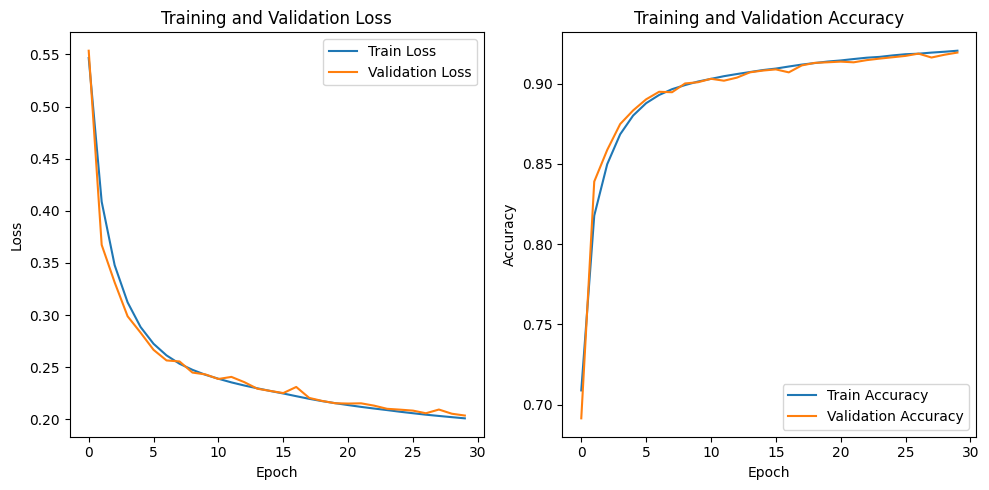

In [ ]:
plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies)

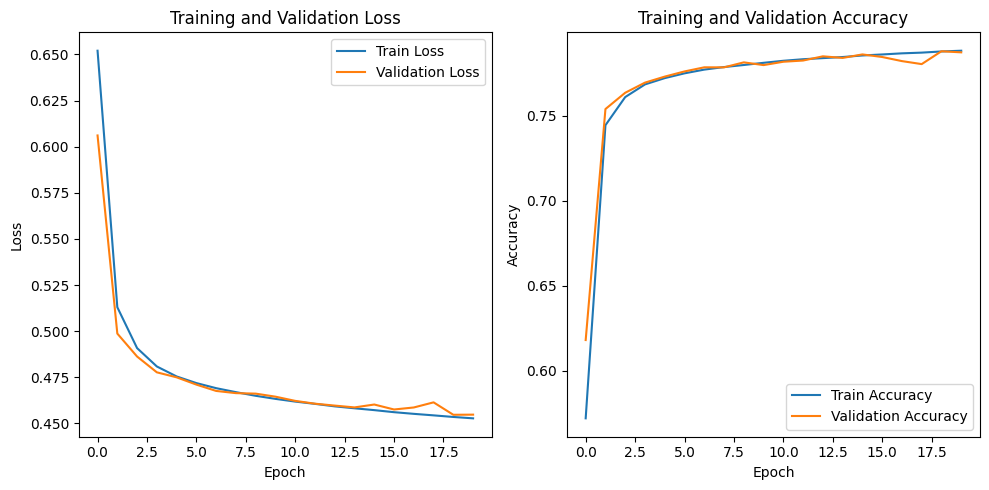

In [ ]:
plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies)

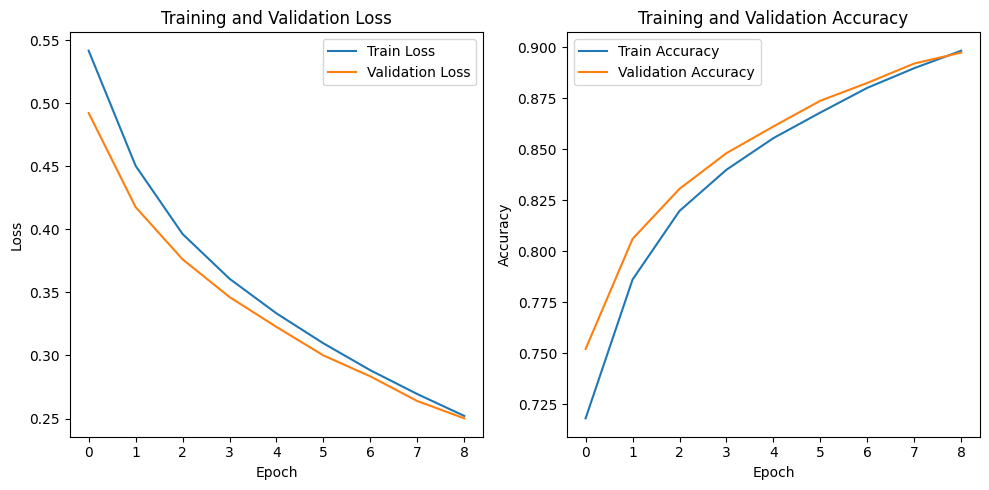

In [ ]:
plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies)

**Predict Function**

In [ ]:
def predict(audio_path1, audio_path2, model_path, threshold=0.5):
    # Load the model
    # Create an instance of the Siamese network in PyTorch
    siamese_network_pt = SiameseNetwork()

    # Create an instance of the Siamese model in PyTorch
    model = SiameseModel(siamese_network_pt).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Preprocess the audio files
    audio1 = preprocess_audio(audio_path1, scaler)
    audio2 = preprocess_audio(audio_path2, scaler)

    # Run the model inference
    with torch.no_grad():
        output = model(audio1, audio2)
        prediction = (output > threshold).long().item()

    return prediction

In [ ]:
def preprocess_audio(file_path,scaler):
    # Define parameters
    sr = 16000
    n_mfcc = 13
    n_fft = 2048
    hop_length = 512
    clip_duration = 1.4

    # Load audio file
    data, samplerate = sf.read(file_path)

    # Take the first clip of specified duration
    step = sr * clip_duration
    audio_clip = data[:int(step)]

    # Extract MFCC features
    mfcc = librosa.feature.mfcc(y=audio_clip, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    mfcc = mfcc.T  # Transpose to get the correct shape

    # Normalize the MFCC features
    mfcc = scaler.fit_transform(mfcc)  # Fit and transform for first input
    mfcc = np.expand_dims(mfcc, axis=0)  # Add batch dimension
    mfcc = np.expand_dims(mfcc, axis=0)  # Add channel dimension

    # Convert to tensor
    return torch.tensor(mfcc).float()

In [ ]:
import pickle
def predict(audio_path1, audio_path2, model_path, threshold=0.5):
    # Load the model architecture
    siamese_network = SiameseNetwork()
    model = SiameseModel(siamese_network).to('cpu')

    # Load the state dictionary
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()

    # Preprocess the audio files
    audio1 = preprocess_audio(audio_path1,scaler)
    audio2 = preprocess_audio(audio_path2,scaler)

    # Move tensors to the same device as model (if using GPU, modify accordingly)
    audio1 = audio1.to('cpu')
    audio2 = audio2.to('cpu')

    # Run the model inference
    with torch.no_grad():
        output = model(audio1, audio2)

    return output

# Example usage
audio_path1 = 'houcine.flac'
audio_path2 = 'chaimaa.flac'
model_path = 'model_epoch_16.pt'
scaler = pickle.load(open('scaler.pkl', 'rb'))

prediction = predict(audio_path1, audio_path2, model_path,scaler)
print("Prediction:", prediction)

Prediction: tensor(1.0234e-06)


In [ ]:
from pydub import AudioSegment

# Load the OGG file
ogg_audio = AudioSegment.from_file("houcine.ogg", format="ogg")

# Export as FLAC
ogg_audio.export("houcine.flac", format="flac")

<_io.BufferedRandom name='houcine.flac'>

**Confusion Matrix**

In [ ]:
def collect_predictions_and_labels(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            x1, x2, labels = batch
            x1, x2, labels = x1.to(device), x2.to(device), labels.to(device)

            outputs = model(x1, x2)
            preds = (outputs > 0.5).long()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

def plot_confusion_matrix(preds, labels):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

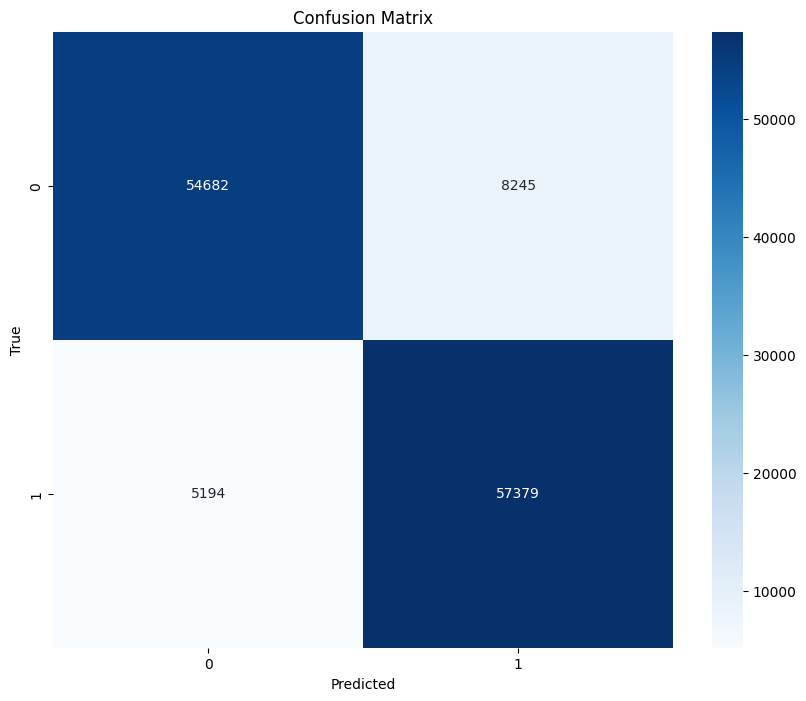

In [ ]:
# Collect predictions and labels from the test set
test_preds, test_labels = collect_predictions_and_labels(model, test_loader, device)

# Plot confusion matrix
plot_confusion_matrix(test_preds, test_labels)

**Roc-Auc Curves**

In [ ]:
from sklearn.metrics import roc_curve, auc
def plot_roc_auc_curve(model, dataloader, device):
    preds, labels = collect_predictions_and_labels(model, dataloader, device)

    fpr, tpr, _ = roc_curve(labels, preds)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

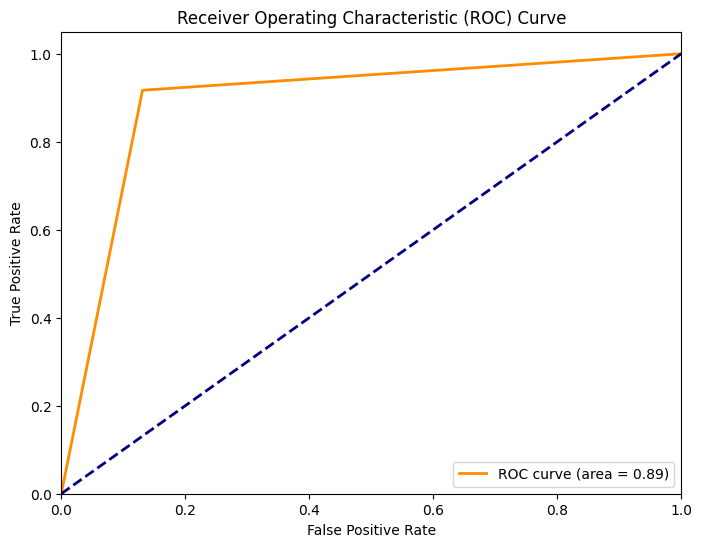

In [ ]:
plot_roc_auc_curve(model, test_loader, device)

**Evaluation**

In [ ]:
def evaluate_model(model, test_loader, threshold=0.5):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for batch in test_loader:
            x1, x2, labels = batch
            outputs = model(x1, x2)
            predictions = (outputs > threshold).long()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    class_report = classification_report(all_labels, all_predictions)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("\nClassification Report:")
    print(class_report)

In [ ]:
# Evaluate the model on the test data
evaluate_model(model, test_loader)

Accuracy: 0.9152987524622456
Precision: 0.9237739029658115
Recall: 0.9079424251838045
F1 Score: 0.9157897485442723

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.92      0.91     18761
         1.0       0.92      0.91      0.92     19314

    accuracy                           0.92     38075
   macro avg       0.92      0.92      0.92     38075
weighted avg       0.92      0.92      0.92     38075

